# 1. Introduction
## Stack Overflow Developer Survey 2024 - Exploratory Data Analysis

 This notebook explores the 2024 Stack Overflow Developer Survey dataset. We will load the data, perform initial inspection, clean it as needed, and conduct exploratory analysis to uncover insights about the developer community.
 
Our goal is to uncover insights about the global developer community by following the CRISP-DM data analysis process. 

The detail of the surey could be obtained in [here](https://survey.stackoverflow.co/2024/)

## 2. Business Understanding

**Key Questions:**
1. What are the most common programming languages among developers ?
2. How does compensation vary by country or experience ?
3. What factors are most associated with higher compensation ?

We will answer these questions using descriptive statistics and visualizations.

## 3.Data Understanding

Let's check the size and structure of the dataset, and review the column names and data types.


In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")

# Print all columns
pd.set_option('display.max_columns', None)

In [45]:
# --- Helper Functions for Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(df, column_name, bins=30):
    """Plots a histogram for a given numeric column in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the numeric column to plot.
        bins (int): The number of bins for the histogram.
    """
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column_name].dropna(), bins=bins, kde=False)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

def plot_scatter(df, x_column, y_column, alpha=0.3, y_limit=None):
    """Plots a scatter plot between two columns in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        x_column (str): The name of the column for the x-axis.
        y_column (str): The name of the column for the y-axis.
        alpha (float): Transparency level for the points.
        y_limit (int, optional): Upper limit for the y-axis. Defaults to None.
    """
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[x_column], y=df[y_column], alpha=alpha)
    plt.title(f'{y_column} vs {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    if y_limit:
        plt.ylim(0, y_limit)
    plt.show()

def plot_boxplot_category(df, category_col, target_col, top_n=20, ylim_max=300000):
    """Plots a boxplot of a target variable grouped by a categorical column.

    Handles high cardinality by showing only top N categories based on count.
    Orders categories by the median of the target variable.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        category_col (str): The name of the categorical column for the x-axis.
        target_col (str): The name of the target numeric column for the y-axis.
        top_n (int): The maximum number of categories to display.
        ylim_max (int): The upper limit for the y-axis.
    """
    plot_data = df.copy() # Work on a copy

    # Handle potential NaN values in category column before value_counts
    plot_data = plot_data.dropna(subset=[category_col])

    if plot_data[category_col].nunique() > top_n:
        print(f"\nShowing Top {top_n} categories for {category_col} based on count.")
        top_categories = plot_data[category_col].value_counts().nlargest(top_n).index
        plot_data = plot_data[plot_data[category_col].isin(top_categories)]

    # Ensure target column is numeric for median calculation
    plot_data[target_col] = pd.to_numeric(plot_data[target_col], errors='coerce')
    plot_data = plot_data.dropna(subset=[target_col]) # Drop rows where target is NaN

    if plot_data.empty or plot_data[category_col].nunique() == 0:
        print(f"No data to plot for {category_col} after filtering.")
        return

    plt.figure(figsize=(12, 6))
    # Calculate order based on median after filtering
    try:
        order = plot_data.groupby(category_col)[target_col].median().sort_values(ascending=False).index
    except KeyError:
        print(f"Could not group by {category_col}. Check column name and data.")
        return

    sns.boxplot(x=category_col, y=target_col, data=plot_data, order=order)
    plt.title(f'{target_col} by {category_col}')
    plt.xlabel(category_col)
    plt.ylabel(target_col)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, ylim_max)
    plt.tight_layout()
    plt.show()



In [46]:
# Load the dataset
df = pd.read_csv('survey_results_public.csv')
schema = pd.read_csv('survey_results_schema.csv')

In [47]:
# Display the first few rows of the dataset
df.head()

ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                                NaN   

                                             EdLevel  \
0                          Primary/elementary school   
1       Bachelor’s degree (B.A., B.S., B.Eng., etc.)   
2    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
3  Some college/university study without earning ...   
4  Secondary school (e.g. American high school, G...   

                                           LearnCode  \
0                             Books / Physical media   
1  Books / Physical media;Colleague;On the job tr...   
2  Books / Physical media;Colleague;On the job tr...   
3  Other online resources (e.g., videos, blogs, f...   
4  Other online resources (e.g., videos, blogs, f...   

                                     LearnCodeOnline  \
0                                                NaN   
1  Technical documentation;Blogs;Books;Written Tu...   
2  Technical documentation;Blogs;Books;Written Tu...   
3  Stack Overflow;How-to videos;Interactive tutorial   
4  Technical documentation;Blogs;Written Tutorial...   

                                             TechDoc YearsCode YearsCodePro  \
0                                                NaN       NaN          NaN   
1  API document(s) and/or SDK document(s);User gu...        20           17   
2  API document(s) and/or SDK document(s);User gu...        37           27   
3                                                NaN         4          NaN   
4  API document(s) and/or SDK document(s);User gu...         9          NaN   

                 DevType OrgSize PurchaseInfluence BuyNewTool BuildvsBuy  \
0                    NaN     NaN               NaN        NaN        NaN   
1  Developer, full-stack     NaN               NaN        NaN        NaN   
2   Developer Experience     NaN               NaN        NaN        NaN   
3  Developer, full-stack     NaN               NaN        NaN        NaN   
4  Developer, full-stack     NaN               NaN        NaN        NaN   

  TechEndorse                                            Country Currency  \
0         NaN                           United States of America      NaN   
1         NaN  United Kingdom of Great Britain and Northern I...      NaN   
2         NaN  United Kingdom of Great Britain and Northern I...      NaN   
3         NaN                                             Canada      NaN   
4         NaN                                             Norway      NaN   

   CompTotal                             LanguageHaveWorkedWith  \
0        NaN                                                NaN   
1        NaN  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...   
2        NaN                                                 C#   
3        NaN  C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...   
4        NaN            C++;HTML/CSS;JavaScript;Lua;Python;Rust   

                              LanguageWantToWorkWith  \
0                                                NaN   
1  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...   
2  

In [48]:
schema.head()

qid       qname                                           question  \
0    QID2  MainBranch  Which of the following options best describes ...   
1  QID127         Age                                 What is your age?*   
2  QID296  Employment  Which of the following best describes your cur...   
3  QID308  RemoteWork  Which best describes your current work situation?   
4  QID341       Check  Just checking to make sure you are paying atte...   

  force_resp type selector  
0       True   MC     SAVR  
1       True   MC     SAVR  
2       True   MC     MAVR  
3      False   MC     SAVR  
4       True   MC     SAVR

Let's examine the structure and contents of the dataset, including the number of rows and columns, data types, and the presence of missing values.

In [49]:
# Shape of the dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 65437
Number of columns: 114


In [50]:
# Show summary statistics for numeric columns
df.describe()


ResponseId      CompTotal       WorkExp  JobSatPoints_1  \
count  65437.000000   3.374000e+04  29658.000000    29324.000000   
mean   32719.000000  2.963841e+145     11.466957       18.581094   
std    18890.179119  5.444117e+147      9.168709       25.966221   
min        1.000000   0.000000e+00      0.000000        0.000000   
25%    16360.000000   6.000000e+04      4.000000        0.000000   
50%    32719.000000   1.100000e+05      9.000000       10.000000   
75%    49078.000000   2.500000e+05     16.000000       22.000000   
max    65437.000000  1.000000e+150     50.000000      100.000000   

       JobSatPoints_4  JobSatPoints_5  JobSatPoints_6  JobSatPoints_7  \
count    29393.000000    29411.000000    29450.000000     29448.00000   
mean         7.522140       10.060857       24.343232        22.96522   
std         18.422661       21.833836       27.089360        27.01774   
min          0.000000        0.000000        0.000000         0.00000   
25%          0.000000        0.000000        0.000000         0.00000   
50%          0.000000        0.000000       20.000000        15.00000   
75%          5.000000       10.000000       30.000000        30.00000   
max        100.000000      100.000000      100.000000       100.00000   

       JobSatPoints_8  JobSatPoints_9  JobSatPoints_10  JobSatPoints_11  \
count    29456.000000    29456.000000     29450.000000     29445.000000   
mean        20.278165       16.169432        10.955713         9.953948   
std         26.108110       24.845032        22.906263        21.775652   
min          0.000000        0.000000         0.000000         0.000000   
25%          0.000000        0.000000         0.000000         0.000000   
50%         10.000000        5.000000         0.000000         0.000000   
75%         25.000000       20.000000        10.000000        10.000000   
max        100.000000      100.000000       100.000000       100.000000   

       ConvertedCompYearly        JobSat  
count         2.343500e+04  29126.000000  
mean          8.615529e+04      6.935041  
std           1.867570e+05      2.088259  
min           1.000000e+00      0.000000  
25%           3.271200e+04      6.000000  
50%           6.500000e+04      7.000000  
75%           1.079715e+05      8.000000  
max           1.625660e+07     10.000000

Before selecting features , it is crucial to systematically understand *all* available columns in the dataset. We will use the `schema.csv` file, which contains the actual question text for each column name (`qname`), to achieve this.

This process involves:
1. Creating a mapping from column names to question text.
2. Iterating trough each column in the main data.
3. For each column, retrievin gits meaning, data type, number of unique values, and percentage of missing values.
4. Summarizing this information to get a comprehensive overview of all potential features.

In [51]:
import pandas as pd
import numpy as np

# --- Load Data (Ensure df and schema are loaded) ---
try:
    # Check if df and schema exist, if not, load them
    if 'df' not in locals() or 'schema' not in locals():
        print("Loading data...")
        df = pd.read_csv('survey_results_public.csv')
        schema = pd.read_csv('survey_results_schema.csv')
        print("Data loaded successfully.")

    # --- Create Schema Dictionary ---
    # Check if schema DataFrame has the expected columns
    if 'qname' in schema.columns and 'question' in schema.columns:
         schema_dict = pd.Series(schema.question.values, index=schema.qname).to_dict()
    else:
         print("Warning: Schema file does not contain 'qname' and 'question'. Cannot map column names to questions.")
         schema_dict = {} # Use an empty dict if mapping is not possible

    # --- Systematically Explore Each Column ---
    column_info_list = []
    print("Starting systematic column exploration...")
    for col in df.columns:
        dtype = df[col].dtype
        unique_count = df[col].nunique()
        missing_percentage = df[col].isnull().mean() * 100
        question_text = schema_dict.get(col, "N/A - Question not found in schema")
        column_info_list.append({
            'Column Name': col,
            'Question': question_text,
            'Data Type': dtype,
            'Unique Values': unique_count,
            'Missing (%)': round(missing_percentage, 2)
        })

    summary_df = pd.DataFrame(column_info_list)

    # --- Display Full Summary Table (Improved Readability) ---
    print("\n--- Full Column Summary ---")
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.width', 1000,
                           'display.max_colwidth', 150): # Adjust colwidth as needed
        print(summary_df)

except FileNotFoundError as e:
    print(f"Error loading data file: {e}")
    print("Please ensure 'survey_results_public.csv' and 'survey_results_schema.csv' are in the correct directory.")
except NameError as e:
    print(f"Error: {e}. Ensure df and schema are loaded correctly.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



Starting systematic column exploration...

--- Full Column Summary ---
                        Column Name                                                                                                                                               Question Data Type  Unique Values  Missing (%)
0                        ResponseId                                                                                                                     N/A - Question not found in schema     int64          65437         0.00
1                        MainBranch                    Which of the following options best describes you today? For the purpose of this survey, a developer is "someone who writes code".*    object              5         0.00
2                               Age                                                                                                                                     What is your age?*    object              8         0.00
3                        Empl

### Analysis of Column Summary (`summary_df`)

The summary table above provides critical insights into the dataset structure:

*   **Data Types:** We see a mix of `int64`, `float64`, and `object` types. `object` columns often represent categorical data (like `EdLevel`, `Country`) or multi-select answers (like `LanguageHaveWorkedWith`) that will require parsing or specific encoding.
*   **Unique Values:** This helps distinguish potential categorical variables (low unique count, e.g., `RemoteWork`, `Age`) from continuous numeric variables (high unique count, e.g., `CompTotal`) or identifiers (`ResponseId`). Columns with very high unique counts and `object` type (e.g., `LanguageHaveWorkedWith`, `LearnCodeOnline`) likely need special handling (parsing, feature extraction).
*   **Missing Values:** Several columns have significant missing data (e.g., `ConvertedCompYearly` at ~64%, `WorkExp` at ~55%, many `JobSatPoints_X` above 50%). This high percentage of missing data, especially in the target variable, will significantly impact our analysis and modeling choices. We will need strategies like dropping rows (especially for the target), imputation, or excluding features with excessive missingness. Columns like `AINextMuch less integrated` (>98% missing) are likely unusable.
*   **Schema Mapping:** Many columns related to specific technologies (Languages, Databases, Platforms etc., indices 22-56, 68-75) are missing question text ("N/A - Question not found in schema"). While their names are indicative, the exact question context is lost, requiring careful interpretation based on the column name alone. `ConvertedCompYearly` also lacks question text in the loaded schema, but its meaning is generally understood as the target variable.

This systematic overview forms the basis for identifying relevant features and planning the data preparation steps.


### Interpreting the Column Summary

The table above provides a comprehensive overview of every column in the dataset:

*   **Column Name:** The name used in the DataFrame (`df`).
*   **Question:** The actual question asked in the survey, providing crucial context about what the data represents.
*   **Data Type:** The data type inferred by pandas (`object`, `int64`, `float64`, etc.). `object` often indicates strings or mixed types.
*   **Unique Values:** The number of distinct values in the column.
    *   Low count (e.g., < 10-20): Likely a categorical variable (like `RemoteWork`, `Age` groups).
    *   Moderate count (e.g., 20-100): Could be categorical (like `Country`), ordinal (like `YearsCode`), or numeric. Needs closer look.
    *   High count: Could be continuous numeric (`CompTotal`), ID (`ResponseId`), or free-text/multi-select (`LanguageHaveWorkedWith`).
*   **Missing (%):** The percentage of missing (NaN) values. High percentages might make a column difficult to use directly without significant imputation or dropping.



In [52]:
# --- Define Criteria for Feature Selection ---
TARGET_VARIABLE = 'ConvertedCompYearly'
MAX_MISSING_PERCENTAGE = 70  # 例: 70%以上欠損しているカラムは除外
MAX_UNIQUE_FOR_CATEGORICAL = 100 # 例: ユニーク数が100を超えるカテゴリカル変数は除外（Countryなどは例外的に含めることも検討）
MIN_UNIQUE_FOR_CONTINUOUS = 50 # 例: ユニーク数が50未満の数値変数はカテゴリカル扱いの可能性も考慮
ID_COLUMN = 'ResponseId'
SURVEY_METADATA_COLS = ['Check', 'SurveyLength', 'SurveyEase'] # 調査自体に関するカラム
EXCLUDE_COLS = [ID_COLUMN, TARGET_VARIABLE] + SURVEY_METADATA_COLS # 除外するカラムリスト

# --- Identify Numeric Candidates ---
numeric_candidates_df = summary_df[
    (summary_df['Data Type'].isin(['int64', 'float64'])) & # データ型が数値
    (summary_df['Missing (%)'] < MAX_MISSING_PERCENTAGE) & # 欠損率が許容範囲内
    # (summary_df['Unique Values'] >= MIN_UNIQUE_FOR_CONTINUOUS) & # ある程度のユニーク数がある (任意)
    (~summary_df['Column Name'].isin(EXCLUDE_COLS)) # 除外リストに含まれない
]
numeric_candidates = numeric_candidates_df['Column Name'].tolist()

# 手動で追加したい数値変数（もしあれば）
# numeric_candidates.extend(['SomeOtherNumeric'])

# 手動で除外したい数値変数（もしあれば）
# numeric_candidates = [col for col in numeric_candidates if col not in ['SomeNumericToExclude']]

print("\n--- Identified Numeric Candidates ---")
print(f"Found {len(numeric_candidates)} candidates:")
print(numeric_candidates)
# print("\nDetails:")
# print(numeric_candidates_df)


# --- Identify Categorical Candidates ---
categorical_candidates_df = summary_df[
    # (summary_df['Data Type'] == 'object') | # データ型がobject、または
    # ((summary_df['Data Type'].isin(['int64', 'float64'])) & (summary_df['Unique Values'] < MIN_UNIQUE_FOR_CONTINUOUS)) | # 数値型だがユニーク数が少ない
    (summary_df['Unique Values'] <= MAX_UNIQUE_FOR_CATEGORICAL) & # ユニーク数が許容範囲内 (Countryなどは別途考慮)
    (summary_df['Missing (%)'] < MAX_MISSING_PERCENTAGE) & # 欠損率が許容範囲内
    (~summary_df['Column Name'].isin(EXCLUDE_COLS + numeric_candidates)) # 除外リストと数値候補に含まれない
]
categorical_candidates = categorical_candidates_df['Column Name'].tolist()

# 例外的に追加したいカテゴリカル変数（例：Country、DevTypeなどユニーク数が多くても重要）
important_high_cardinality = ['Country', 'DevType', 'Employment', 'Industry'] # 例
for col in important_high_cardinality:
     if col in summary_df['Column Name'].values and col not in categorical_candidates and col not in EXCLUDE_COLS + numeric_candidates:
          if summary_df.loc[summary_df['Column Name'] == col, 'Missing (%)'].iloc[0] < MAX_MISSING_PERCENTAGE:
               categorical_candidates.append(col)


# 手動で除外したいカテゴリカル変数（もしあれば）
# categorical_candidates = [col for col in categorical_candidates if col not in ['SomeCategoricalToExclude']]

print("\n--- Identified Categorical Candidates ---")
print(f"Found {len(categorical_candidates)} candidates:")
print(categorical_candidates)
# print("\nDetails:")
# print(categorical_candidates_df)

# --- Identify Columns for Special Handling (High Cardinality or Multi-Select) ---
special_handling_cols = summary_df[
    (summary_df['Unique Values'] > MAX_UNIQUE_FOR_CATEGORICAL) &
    (summary_df['Missing (%)'] < MAX_MISSING_PERCENTAGE) &
    (~summary_df['Column Name'].isin(EXCLUDE_COLS + numeric_candidates + categorical_candidates + important_high_cardinality))
]['Column Name'].tolist()

print("\n--- Columns potentially needing special handling (e.g., parsing multi-select, grouping) ---")
print(special_handling_cols)




--- Identified Numeric Candidates ---
Found 12 candidates:
['CompTotal', 'WorkExp', 'JobSatPoints_1', 'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7', 'JobSatPoints_8', 'JobSatPoints_9', 'JobSatPoints_10', 'JobSatPoints_11', 'JobSat']

--- Identified Categorical Candidates ---
Found 41 candidates:
['MainBranch', 'Age', 'RemoteWork', 'EdLevel', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'PurchaseInfluence', 'BuildvsBuy', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq', 'SOComm', 'AISelect', 'AISent', 'AIAcc', 'AIComplex', 'AIThreat', 'TBranch', 'ICorPM', 'Knowledge_1', 'Knowledge_2', 'Knowledge_3', 'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 'Knowledge_8', 'Knowledge_9', 'Frequency_1', 'Frequency_2', 'Frequency_3', 'TimeSearching', 'TimeAnswering', 'ProfessionalCloud', 'ProfessionalQuestion', 'Industry', 'Country', 'Employment']

--- Columns potentially needing special handling (e.g., parsing multi-select, grouping) ---
['CodingActi

### Identifying Candidate Features

Based on this summary table, we can now make more informed decisions about potential features for predicting `ConvertedCompYearly`:

1.  **Identify Numeric Candidates:** Look for columns with `float64` or `int64` data types that represent quantities relevant to compensation (e.g., `WorkExp`, `YearsCodePro`). Check their missing percentages.
2.  **Identify Categorical Candidates:** Look for columns with `object` or `int64` data types and a reasonable number of unique values (e.g., `EdLevel`, `DevType`, `Country`, `RemoteWork`, `OrgSize`, `Age`). Check their missing percentages. Columns with very high unique values (`LanguageHaveWorkedWith`, `Employment`) need special attention (parsing, grouping, etc.) if considered.
3.  **Exclude Irrelevant Columns:** Columns like `ResponseId` (unique identifier) or columns with extremely high missing values might be excluded initially. Columns representing the survey itself (`SurveyLength`, `SurveyEase`) are unlikely predictors of compensation.

**Next Steps:**

After reviewing this summary, we can confidently create our `numeric_candidates` and `categorical_candidates` lists based on the column meanings, data types, unique counts, and missing data. Then, we proceed with the detailed exploration (visualizing distributions and relationships with the target) for *only these selected candidates*, as demonstrated in the previous steps.


### Target Variable Distribution (`ConvertedCompYearly`)

The distribution of `ConvertedCompYearly` is heavily right-skewed, with many respondents reporting lower salaries and a long tail of high earners. The boxplot also highlights numerous outliers on the higher end.


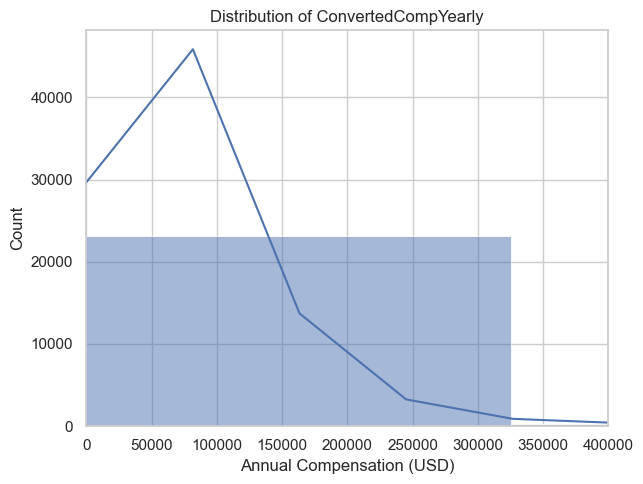

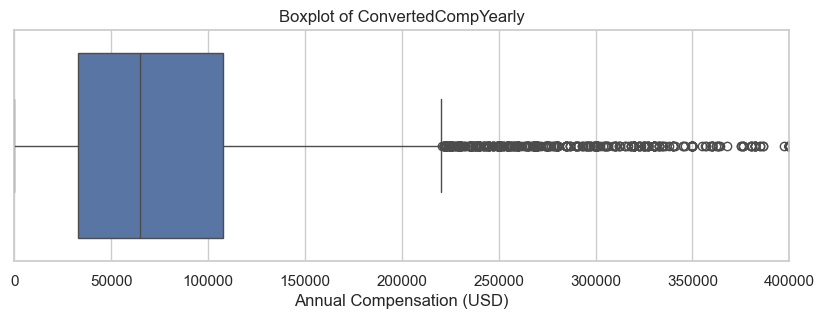

In [53]:
# --- Exploring the Target Variable (Enhanced) ---
TARGET = 'ConvertedCompYearly'
df_analysis_target = df.dropna(subset=[TARGET]).copy() # Use a specific copy just for target analysis

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_analysis_target[TARGET], bins=50, kde=True)
plt.title('Distribution of ConvertedCompYearly')
plt.xlabel('Annual Compensation (USD)')
plt.xlim(0, 400000) # Limit x-axis for better visibility


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(x=df_analysis_target[TARGET])
plt.title('Boxplot of ConvertedCompYearly')
plt.xlabel('Annual Compensation (USD)')
plt.xlim(0, 400000) # Limit x-axis
plt.show()


## 4. Data Preparation

In this section, we will prepare the data for analysis and modeling based on the insights gained during Data Understanding. This includes handling missing values, converting data types, and potentially parsing complex columns. We aim to create a cleaner dataset suitable for the subsequent steps.


In [54]:
# --- Create a copy for cleaning ---
# It's good practice to work on a copy
df_cleaned = df.copy()

# --- Handle Target Variable Missing Values ---
# For modeling compensation, we must drop rows where the target is missing.
# We noted ~64% missingness, significantly reducing our modeling dataset size.
df_cleaned.dropna(subset=['ConvertedCompYearly'], inplace=True)
print(f"Shape after dropping rows with missing ConvertedCompYearly: {df_cleaned.shape}")

# --- Handle Specific Column Parsing (Example: Languages from Q1) ---
# This parsing was done in Q1 EDA, moving it here for better organization.
# Rationale: Split semicolon-separated strings into lists for easier counting/analysis.
if 'LanguageHaveWorkedWith' in df_cleaned.columns:
    df_cleaned['LanguageHaveWorkedWith_List'] = df_cleaned['LanguageHaveWorkedWith'].fillna('').apply(lambda x: x.split(';') if isinstance(x, str) and x else [])
    # Note: Original 'LanguageHaveWorkedWith' string column is kept for now.

# --- Handle Numeric Column Conversion and Imputation (from Q5 Preprocessing) ---
# Rationale: Columns like 'WorkExp' and 'YearsCodePro' contain non-numeric strings
# ('Less than 1 year', 'More than 50 years' are not present in this dataset, but general practice)
# and NaNs. We convert them to numeric, coercing errors to NaN, then impute NaNs
# using the median, which is robust to outliers often seen in experience data.

numeric_cols_to_process = ['WorkExp', 'YearsCodePro'] # Add others if identified
print(f"\n--- Processing Numeric Columns: {numeric_cols_to_process} ---")
for col in numeric_cols_to_process:
    if col in df_cleaned.columns:
        original_missing = df_cleaned[col].isnull().sum()
        # Convert to numeric, errors become NaN
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
        converted_missing = df_cleaned[col].isnull().sum()
        print(f"Column '{col}': Found {converted_missing - original_missing} non-numeric values converted to NaN.")

        # Calculate median *after* conversion
        median_val = df_cleaned[col].median()
        print(f"Column '{col}': Imputing {converted_missing} NaNs with median value {median_val}.")
        # Impute using assignment (avoids FutureWarning)
        df_cleaned[col] = df_cleaned[col].fillna(median_val)

# --- Handle Categorical Column Missing Values (from Q3 Preprocessing) ---
# Rationale: For categorical features used in the model, we'll impute NaNs
# with a placeholder string 'Unknown'. This treats missingness as a separate category.
# Select candidate categorical columns identified earlier (adjust this list based on actual selection for model)
# 
# model_categorical_features = ['EdLevel', 'DevType', 'Country', 'RemoteWork', 'OrgSize', 'Age'] # Example list, refine this!

print(f"\n--- Imputing NaNs in Categorical Columns with 'Unknown': ---")
for col in categorical_candidates:
    if col in df_cleaned.columns:
        missing_count = df_cleaned[col].isnull().sum()
        if missing_count > 0:
            print(f"Column '{col}': Imputing {missing_count} NaNs with 'Unknown'.")
            df_cleaned[col] = df_cleaned[col].fillna('Unknown')

# --- Final Check for NaNs in selected modeling features (Optional here, done before modeling too) ---
# Rationale: Ensure the primary features intended for the model are clean before EDA.
# selected_features_for_check = numeric_cols_to_process + model_categorical_features + ['ConvertedCompYearly']
# print("\nNaN check in selected features post-preparation:")
# print(df_cleaned[selected_features_for_check].isnull().sum())

print("\nData Preparation Complete.")


Shape after dropping rows with missing ConvertedCompYearly: (23435, 114)

--- Processing Numeric Columns: ['WorkExp', 'YearsCodePro'] ---
Column 'WorkExp': Found 0 non-numeric values converted to NaN.
Column 'WorkExp': Imputing 7291 NaNs with median value 9.0.
Column 'YearsCodePro': Found 671 non-numeric values converted to NaN.
Column 'YearsCodePro': Imputing 761 NaNs with median value 8.0.

--- Imputing NaNs in Categorical Columns with 'Unknown': ---
Column 'RemoteWork': Imputing 8 NaNs with 'Unknown'.
Column 'YearsCode': Imputing 47 NaNs with 'Unknown'.
Column 'DevType': Imputing 32 NaNs with 'Unknown'.
Column 'OrgSize': Imputing 25 NaNs with 'Unknown'.
Column 'PurchaseInfluence': Imputing 40 NaNs with 'Unknown'.
Column 'BuildvsBuy': Imputing 1475 NaNs with 'Unknown'.
Column 'SOVisitFreq': Imputing 117 NaNs with 'Unknown'.
Column 'SOAccount': Imputing 114 NaNs with 'Unknown'.
Column 'SOPartFreq': Imputing 5134 NaNs with 'Unknown'.
Column 'SOComm': Imputing 143 NaNs with 'Unknown'.
C

### Data Preparation Summary

Key preparation steps performed:
*   Rows with missing target variable (`ConvertedCompYearly`) were removed.
*   Multi-select string columns (like `LanguageHaveWorkedWith`) were parsed into lists (example shown).
*   Numeric columns relevant for modeling (`WorkExp`, `YearsCodePro`) were converted to numeric type, and missing values were imputed using the median.
*   Categorical columns selected for modeling had their missing values imputed with the string 'Unknown'.

The resulting `df_cleaned` DataFrame is now ready for Exploratory Data Analysis and Modeling, focusing on the non-missing target variable and processed features. Note that decisions on feature selection for the final model will happen later, but basic cleaning is done here.


## 5. Exploratory Data Analysis（EDA）

### Exploratory Data Analysis

Let's explore the data to answer our business questions.


### Q1: What are the most common programming languages among developers?


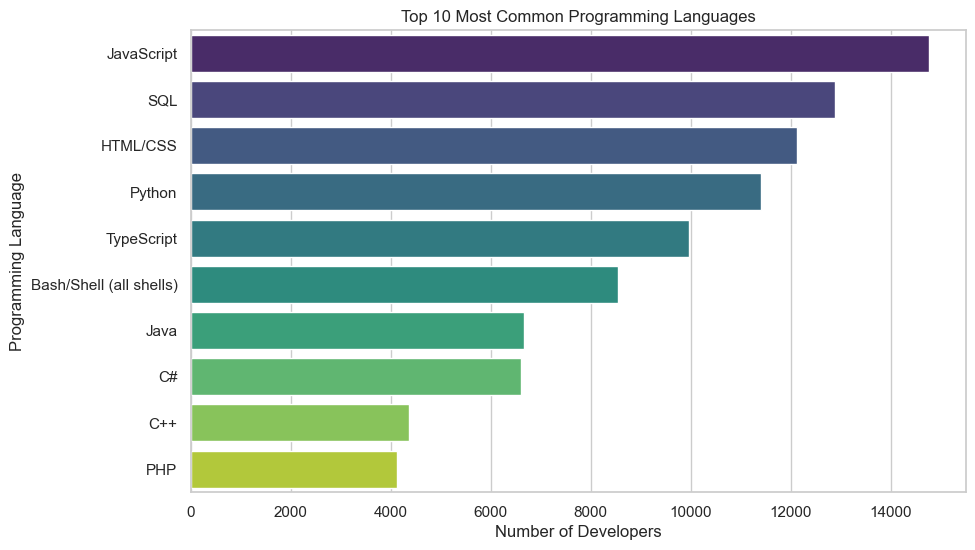

In [55]:
# Q1 Code - Use df_cleaned
from collections import Counter

# Flatten all languages into a single list using the parsed list column
all_langs = [lang for sublist in df_cleaned['LanguageHaveWorkedWith_List'] for lang in sublist if lang]
lang_counts = Counter(all_langs)
top_langs = lang_counts.most_common(10)

# Plot
langs, counts = zip(*top_langs)
plt.figure(figsize=(10, 6))
# Fix warning: assign y to hue and disable legend
sns.barplot(x=list(counts), y=list(langs), hue=list(langs), palette="viridis", legend=False)
plt.title("Top 10 Most Common Programming Languages")
plt.xlabel("Number of Developers")
plt.ylabel("Programming Language")
plt.show()



#### Q1 Interpretation: Most Common Languages

The bar chart shows the top 10 programming languages reported by respondents who worked with them in the past year. **JavaScript, SQL, and HTML/CSS** are the most common, highlighting the prevalence of web development technologies. Python and TypeScript follow.


### Q2: How does compensation vary by country?


### Determining a Sufficient Sample Size for Country Analysis

To ensure reliable country-level comparisons, I need to decide on a minimum sample size per country. 


### Distribution of Response Counts per Country: Interpretation

This histogram shows the number of survey responses for each country. 
**Conclusion:**
Based on the distribution shown in the histogram and common research practices aiming for statistical reliability, I chose a threshold of **200 responses** per country. This threshold excludes countries with very few data points, reducing the influence of outliers and noise, while still retaining a reasonable number of countries (47) for comparison.


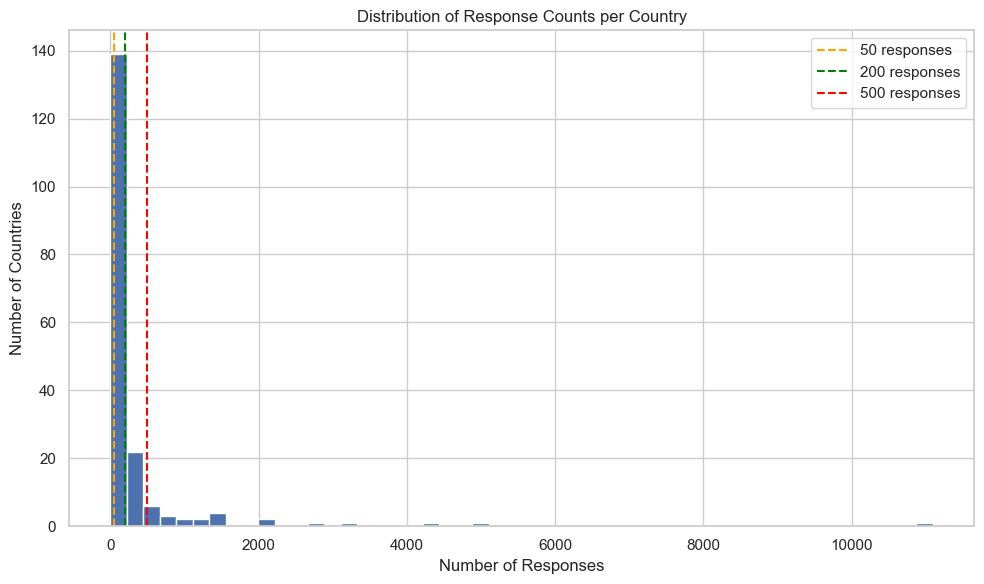

In [56]:
import matplotlib.pyplot as plt

country_counts = df['Country'].value_counts()

plt.figure(figsize=(10,6))
country_counts.hist(bins=50)
plt.axvline(50, color='orange', linestyle='--', label='50 responses')
plt.axvline(200, color='green', linestyle='--', label='200 responses')
plt.axvline(500, color='red', linestyle='--', label='500 responses')
plt.title('Distribution of Response Counts per Country')
plt.xlabel('Number of Responses')
plt.ylabel('Number of Countries')
plt.legend()
plt.tight_layout()
plt.show()


Number of countries with at least 200 responses (in df_cleaned): 22


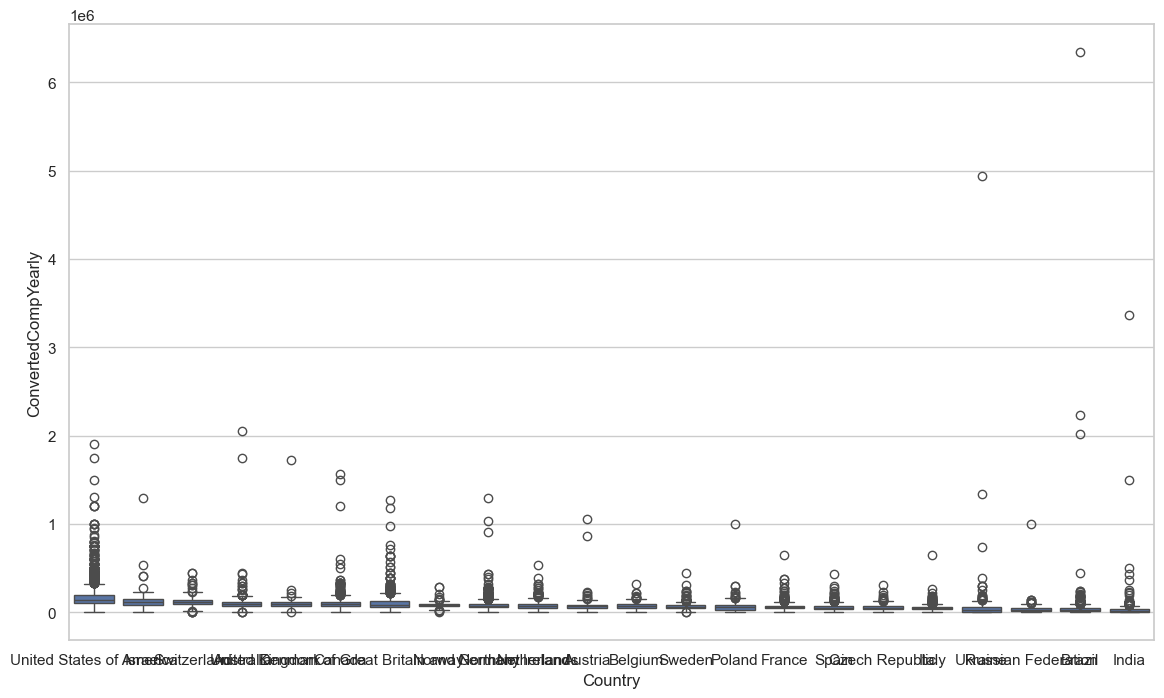

In [57]:
# Q2 Code - Use df_cleaned and the threshold
import plotly.express as px
import pycountry

threshold = 200
country_counts_overall = df_cleaned['Country'].value_counts() # Use df_cleaned for consistency
valid_countries = country_counts_overall[country_counts_overall >= threshold].index
print(f"Number of countries with at least {threshold} responses (in df_cleaned): {len(valid_countries)}")

# Filter df_cleaned further (already filtered by target NaN)
df_q2_analysis = df_cleaned[df_cleaned['Country'].isin(valid_countries)]

# Boxplot code (use df_q2_analysis)
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='Country',
    y='ConvertedCompYearly',
    data=df_q2_analysis, # Use filtered data
    order=df_q2_analysis.groupby('Country')['ConvertedCompYearly'].median().sort_values(ascending=False).index
)
# ... (rest of plot code) ...
plt.show()

# Choropleth map code (use df_q2_analysis)
country_median = df_q2_analysis.groupby('Country')['ConvertedCompYearly'].median().reset_index() # Use filtered data
# ... (rest of ISO conversion and plotting code) ...
# 世界地図の作成

def get_iso3(country_name):
    """Converts a country name to its ISO 3166-1 alpha-3 code.

    Handles common variations for UK, USA, and Russia manually. Returns None
    if the country name cannot be looked up or mapped.

    Args:
        country_name (str): The name of the country.

    Returns:
        str or None: The 3-letter ISO country code, or None if not found.
    """
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        # Special cases manual mapping
        country_map = {
            'United Kingdom of Great Britain and Northern Ireland': 'GBR',
            'United States of America': 'USA',
            'Russian Federation': 'RUS',
            # Add other countries if needed
        }
        return country_map.get(country_name)

# ISO3コードを追加
country_median['iso_alpha'] = country_median['Country'].apply(get_iso3)

# NaNを含む行を削除
country_median = country_median.dropna(subset=['iso_alpha'])

fig = px.choropleth(
    country_median,
    locations="iso_alpha",
    color="ConvertedCompYearly",
    hover_name="Country",
    color_continuous_scale=px.colors.sequential.Plasma,
    projection="natural earth",
    title="Median Annual Compensation by Country (Countries with Sufficient Sample Size)"
)

# レイアウトの調整
fig.update_layout(
    margin={"r":0,"t":30,"l":0,"b":0},
    coloraxis_colorbar=dict(
        title="Median Annual<br>Compensation (USD)"
    )
)

# 地図を表示
fig.show()


#### Q2 Interpretation: Compensation by Country (Filtered)

The boxplot and choropleth map display the median annual compensation for countries with **at least 200 responses**.

*   **Findings:** Clear disparities exist. Countries like the **United States, Switzerland, and Israel** show significantly higher median compensations compared to others like **India, Brazil, or Ukraine** within this filtered group. The map visually reinforces geographic patterns, with North America, Western Europe, and Oceania generally showing higher compensation levels.
*   **Limitations & Reliability:** By focusing on countries with sufficient sample sizes, these results are more reliable than an analysis including all countries. However, the initial geographic bias towards North America and Europe in the survey respondents means these findings still primarily reflect trends in those regions. Compensation in underrepresented regions cannot be reliably inferred from this data.



## Q3: What factors are most associated with higher compensation?

### Feature Exploration Strategy

Before building a model, we first explore features identified as potential candidates from our **systematic column analysis (`summary_df`)**. We will focus on the `numeric_candidates` and `categorical_candidates` lists generated based on data type, missing values, and unique counts. Columns identified as needing 'special handling' (high cardinality, multi-select) will be excluded from this initial modeling phase for simplicity but could be incorporated later for potential model improvement.

*(Insert the code block here that generates `numeric_candidates`, `categorical_candidates`, `special_handling_cols` from `summary_df`, as provided in the previous answer. Ensure it runs correctly after the Data Understanding section where `summary_df` is created.)*

Now, we proceed to explore the relationship between these *selected* candidates and the target variable.
Feature Exploration

Before building a predictive model for 'ConvertedCompYearly', we need to explore potential predictor variables (features). This involves:

1. Identifying candidate features (numeric and categorical).
2. Understanding the distribution and missing values for each candidate.
3. Visualizing the relationsihp between each candidate feature and the target variable.

This exploration will help us select relevant features and inform the preprocessing steps for modeling.


--- Exploring Identified Numeric Features ---
CompTotal             0
WorkExp               0
JobSatPoints_1     7315
JobSatPoints_4     7282
JobSatPoints_5     7270
JobSatPoints_6     7250
JobSatPoints_7     7248
JobSatPoints_8     7245
JobSatPoints_9     7250
JobSatPoints_10    7247
JobSatPoints_11    7250
JobSat             7360
dtype: int64

           CompTotal       WorkExp  JobSatPoints_1  JobSatPoints_4  \
count  2.343500e+04  23435.000000    16120.000000    16153.000000   
mean   2.447967e+07     10.462556       18.409646        7.418142   
std    6.834232e+08      7.437922       25.229052       17.978830   
min    1.000000e+00      0.000000        0.000000        0.000000   
25%    5.800000e+04      6.000000        0.000000        0.000000   
50%    1.075000e+05      9.000000       10.000000        0.000000   
75%    2.500000e+05     12.000000       20.000000        5.000000   
max    5.000000e+10     50.000000      100.000000      100.000000   

       JobSatPoints_5  JobSa

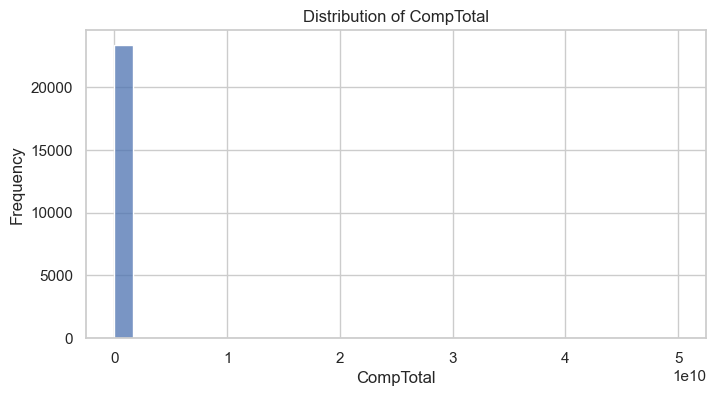

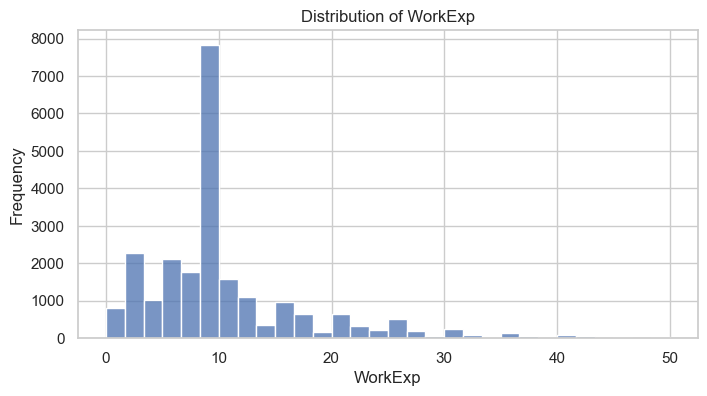

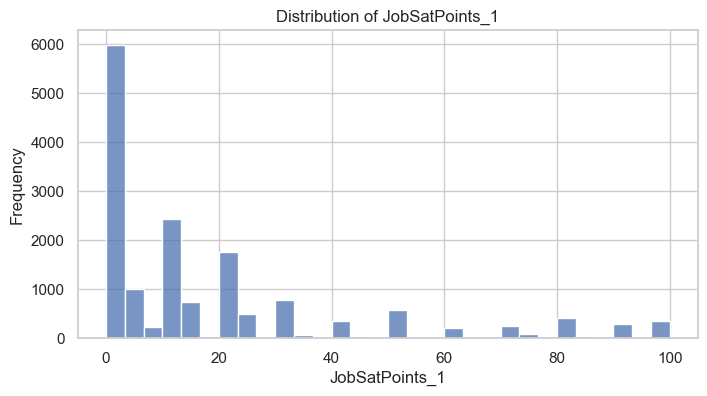

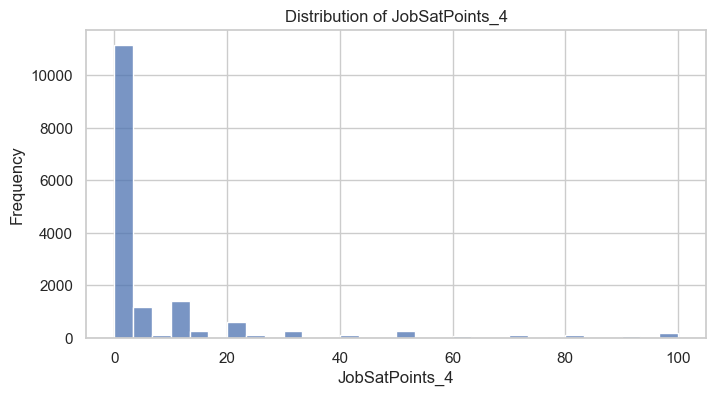

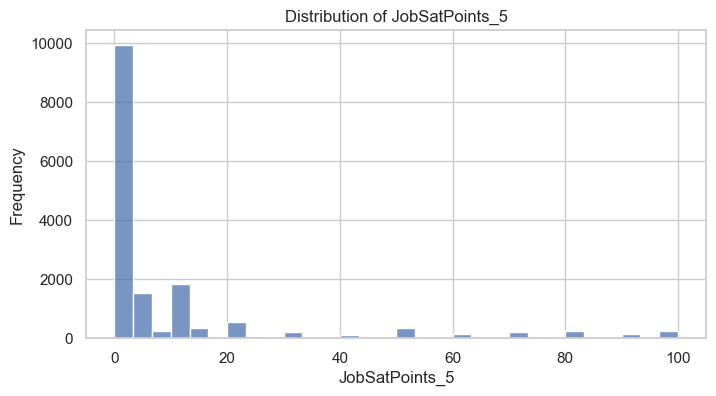

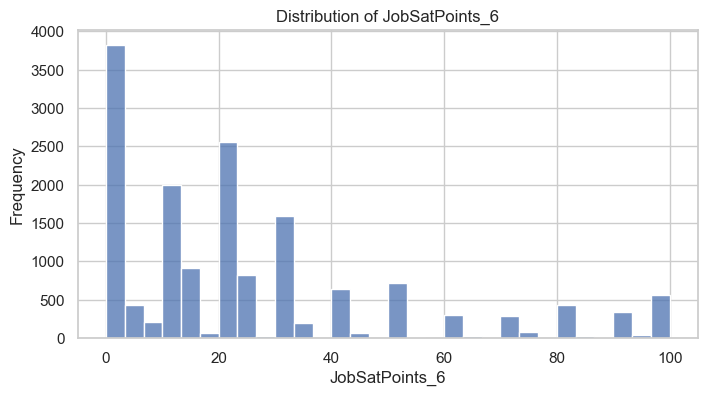

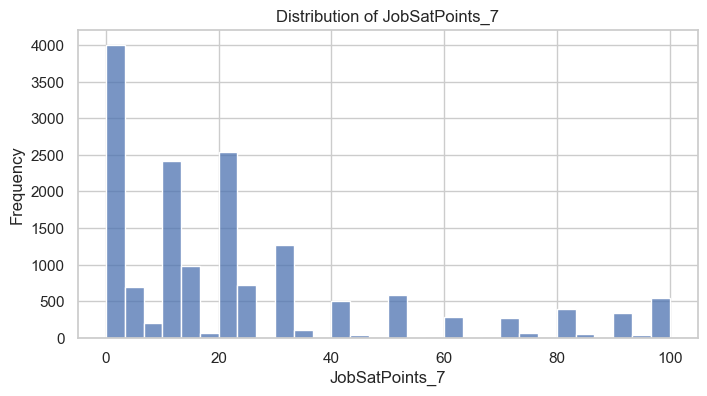

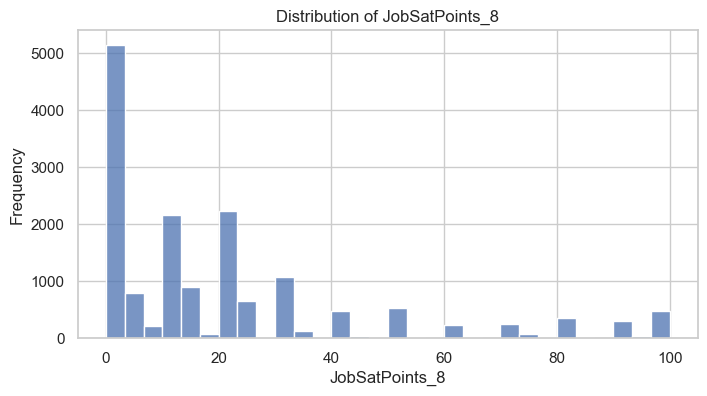

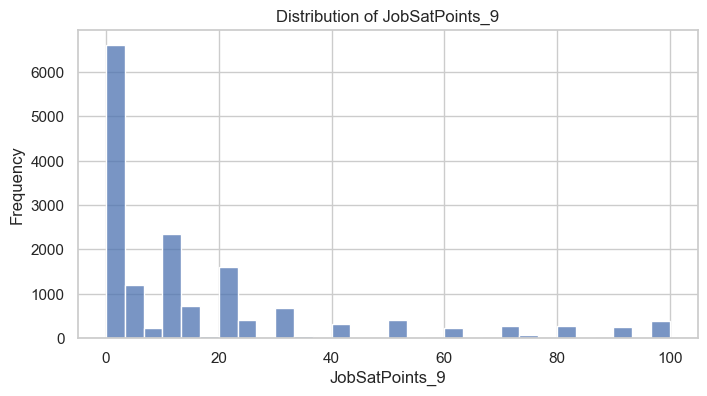

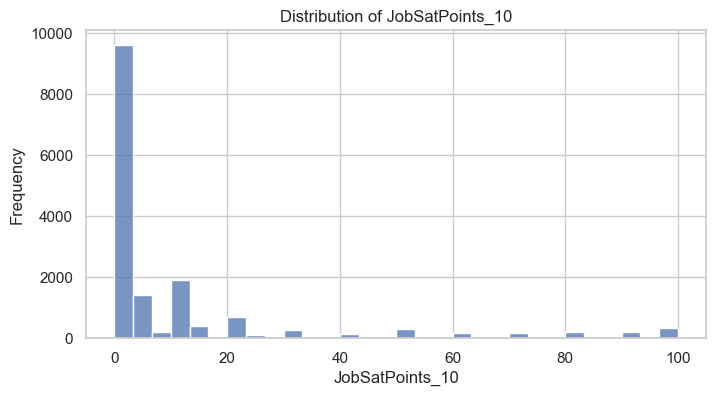

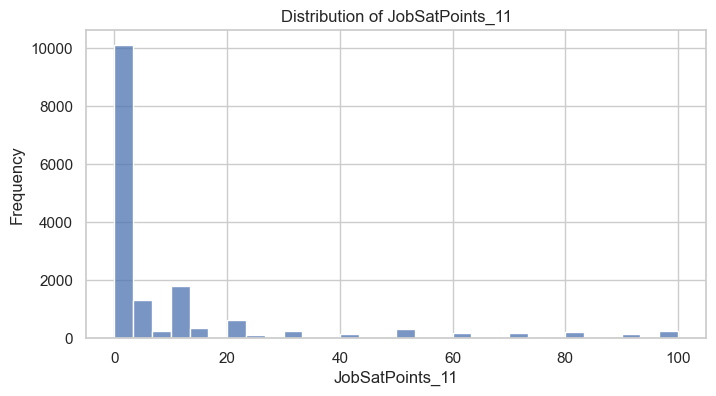

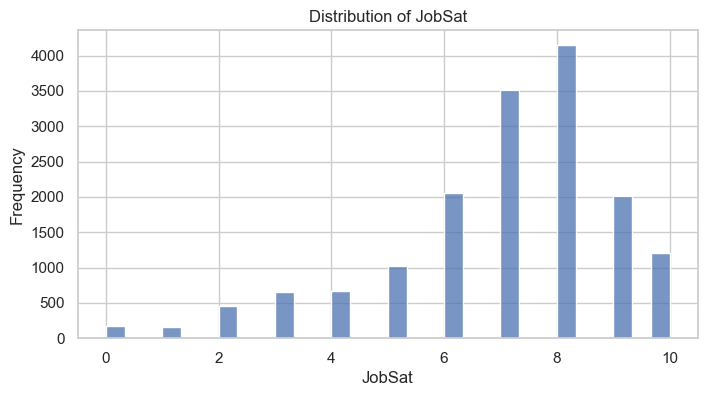


--- Visualizing Numeric vs Target ---


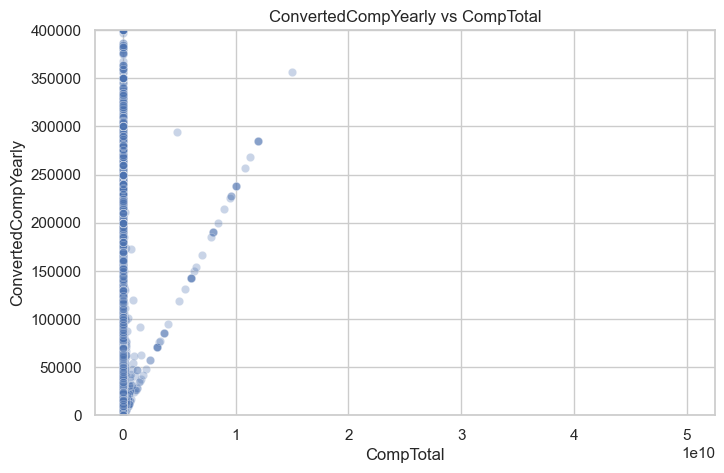

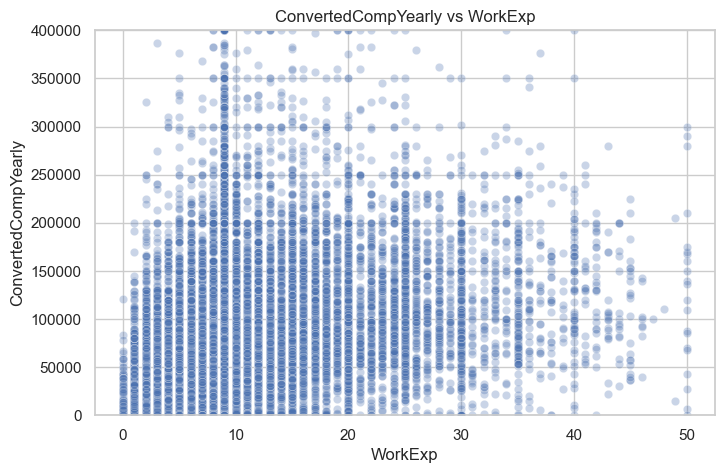

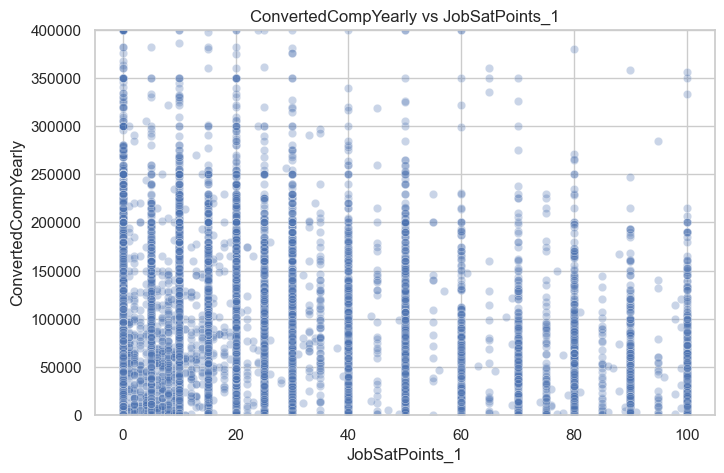

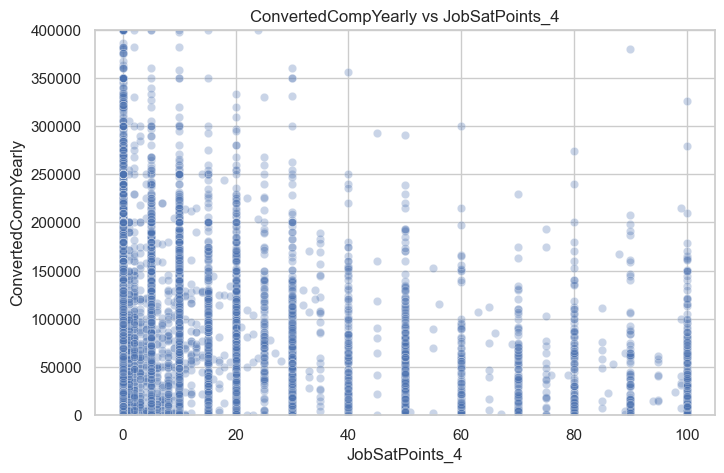

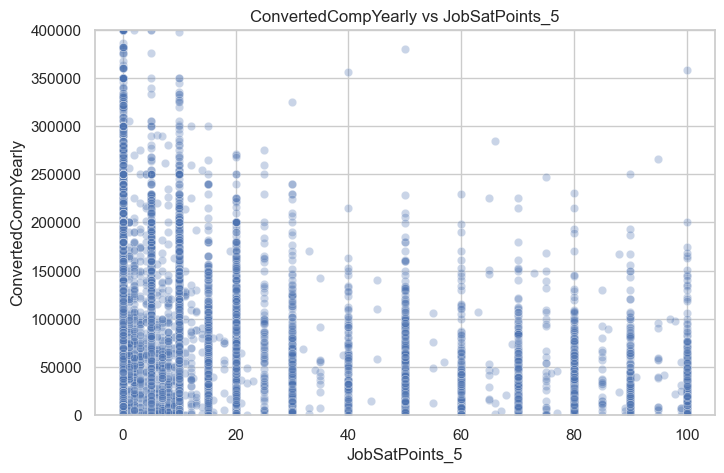

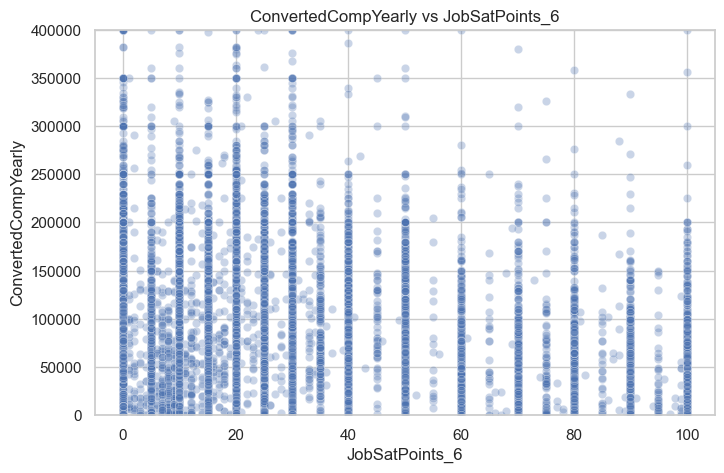

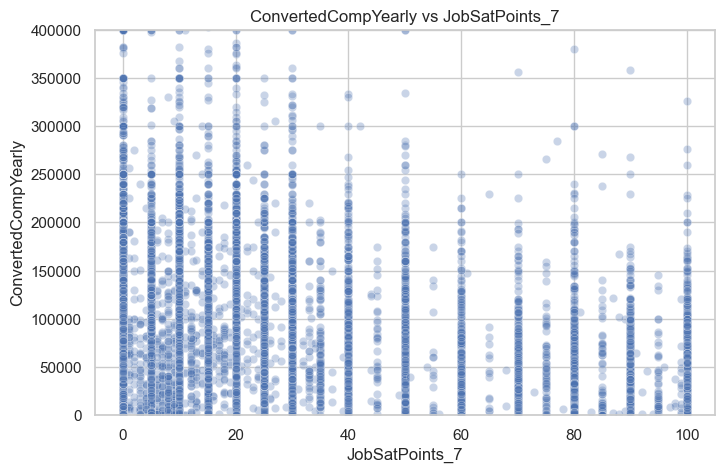

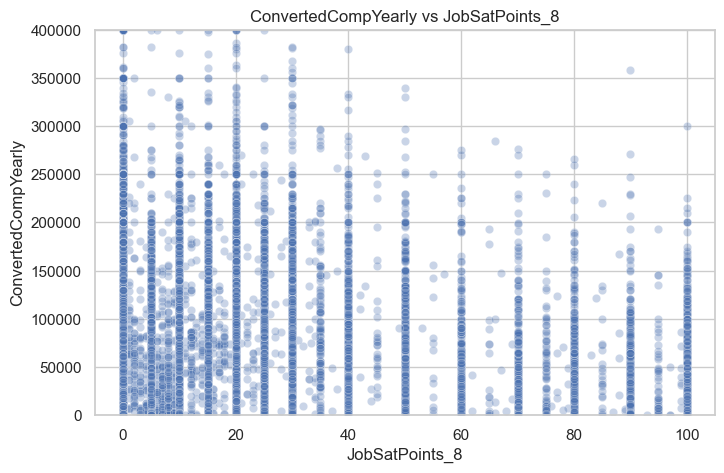

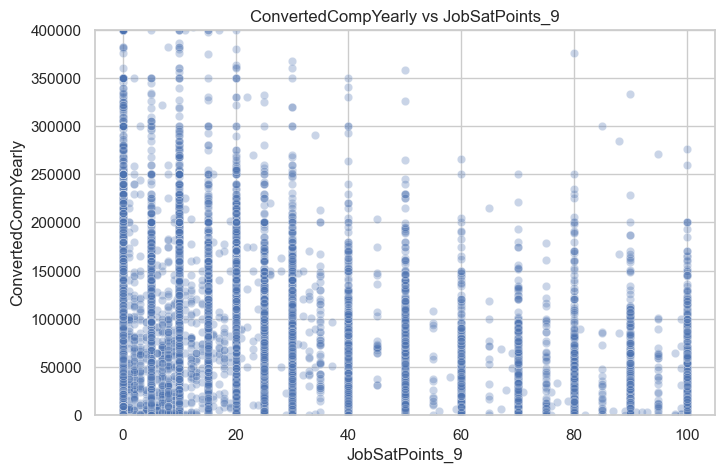

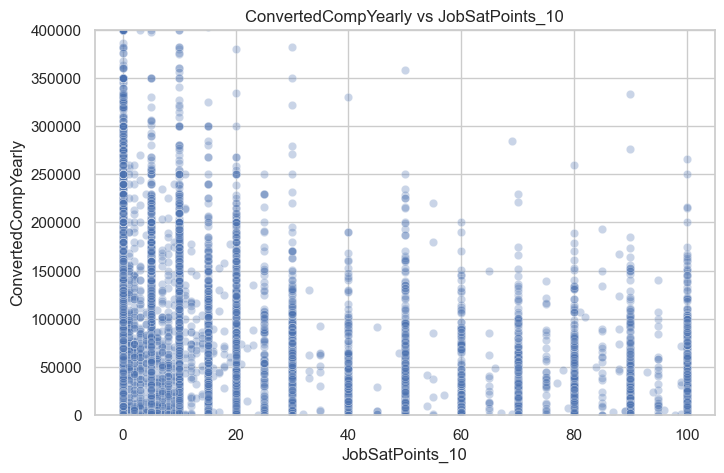

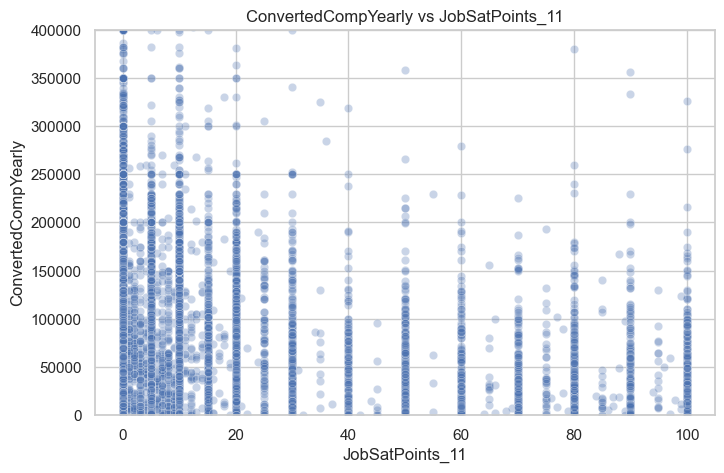

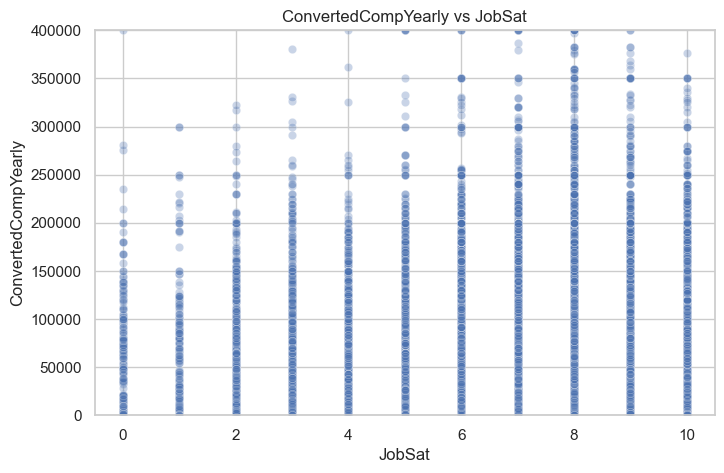

In [58]:
# --- Exploring Potential Numeric Features (Using generated list) ---
print("\n--- Exploring Identified Numeric Features ---")
# Use the list generated from summary_df
print(df_cleaned[numeric_candidates].isnull().sum()) # Use df_cleaned
print("\n", df_cleaned[numeric_candidates].describe())

# Visualize distributions using the helper function
print("\n--- Visualizing Numeric Distributions ---")
# Use the list generated from summary_df
for col in numeric_candidates:
    if pd.api.types.is_numeric_dtype(df_cleaned[col]): # Check if column is actually numeric before plotting
        plot_histogram(df_cleaned, col) # Call the function
    else:
        print(f"Skipping histogram for non-numeric column: {col}")


# Visualize relationship with target using the helper function
print("\n--- Visualizing Numeric vs Target ---")
# Use the list generated from summary_df
for col in numeric_candidates:
     if pd.api.types.is_numeric_dtype(df_cleaned[col]): # Check if column is numeric
        plot_scatter(df_cleaned, col, TARGET_VARIABLE, y_limit=400000) # Call the function
     else:
        print(f"Skipping scatter plot for non-numeric column: {col}")



In [59]:
# --- Exploring Potential Categorical Features (Using generated list) ---
print("\n--- Exploring Identified Categorical Features ---")
# Use the list generated from summary_df
print(df_cleaned[categorical_candidates].isnull().sum()) # Use df_cleaned

# Visualize relationship with target
# Use the list generated from summary_df
for col in categorical_candidates:
    # (Keep the plotting logic with top_n handling)
    # ... use df_cleaned for plot_data ...
    # plot_data = df_cleaned[df_cleaned[col].isin(top_categories)] etc.
    # ...
    plt.show()




--- Exploring Identified Categorical Features ---
MainBranch              0
Age                     0
RemoteWork              0
EdLevel                 0
YearsCode               0
YearsCodePro            0
DevType                 0
OrgSize                 0
PurchaseInfluence       0
BuildvsBuy              0
NEWSOSites              0
SOVisitFreq             0
SOAccount               0
SOPartFreq              0
SOComm                  0
AISelect                0
AISent                  0
AIAcc                   0
AIComplex               0
AIThreat                0
TBranch                 0
ICorPM                  0
Knowledge_1             0
Knowledge_2             0
Knowledge_3             0
Knowledge_4             0
Knowledge_5             0
Knowledge_6             0
Knowledge_7             0
Knowledge_8             0
Knowledge_9             0
Frequency_1             0
Frequency_2             0
Frequency_3             0
TimeSearching           0
TimeAnswering           0
ProfessionalC


--- Exploring Identified Categorical Features ---
MainBranch              0
Age                     0
RemoteWork              0
EdLevel                 0
YearsCode               0
YearsCodePro            0
DevType                 0
OrgSize                 0
PurchaseInfluence       0
BuildvsBuy              0
NEWSOSites              0
SOVisitFreq             0
SOAccount               0
SOPartFreq              0
SOComm                  0
AISelect                0
AISent                  0
AIAcc                   0
AIComplex               0
AIThreat                0
TBranch                 0
ICorPM                  0
Knowledge_1             0
Knowledge_2             0
Knowledge_3             0
Knowledge_4             0
Knowledge_5             0
Knowledge_6             0
Knowledge_7             0
Knowledge_8             0
Knowledge_9             0
Frequency_1             0
Frequency_2             0
Frequency_3             0
TimeSearching           0
TimeAnswering           0
ProfessionalC

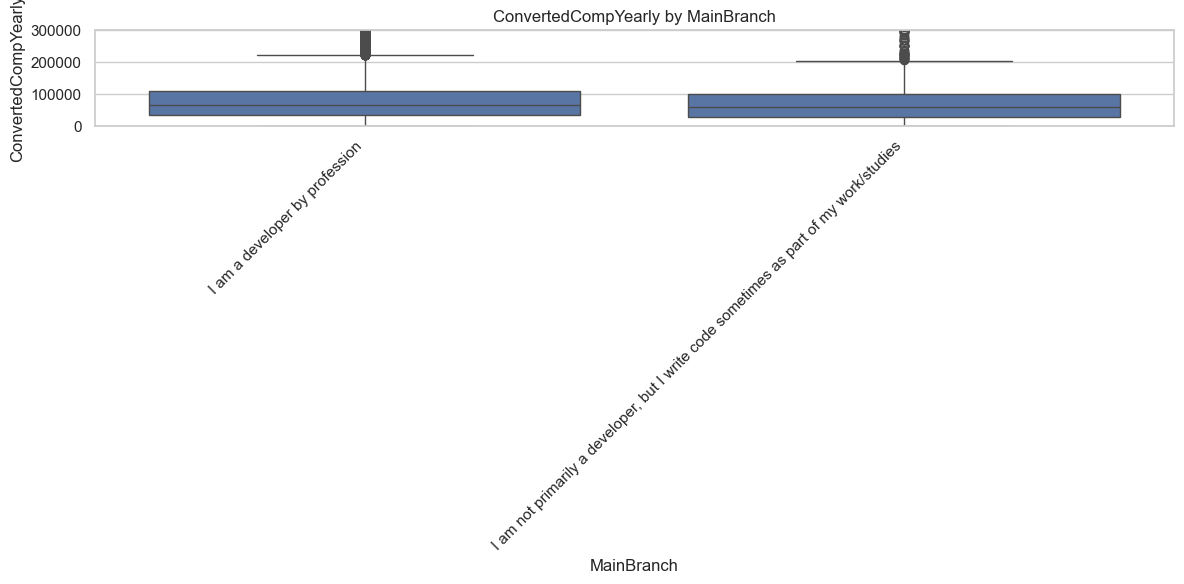

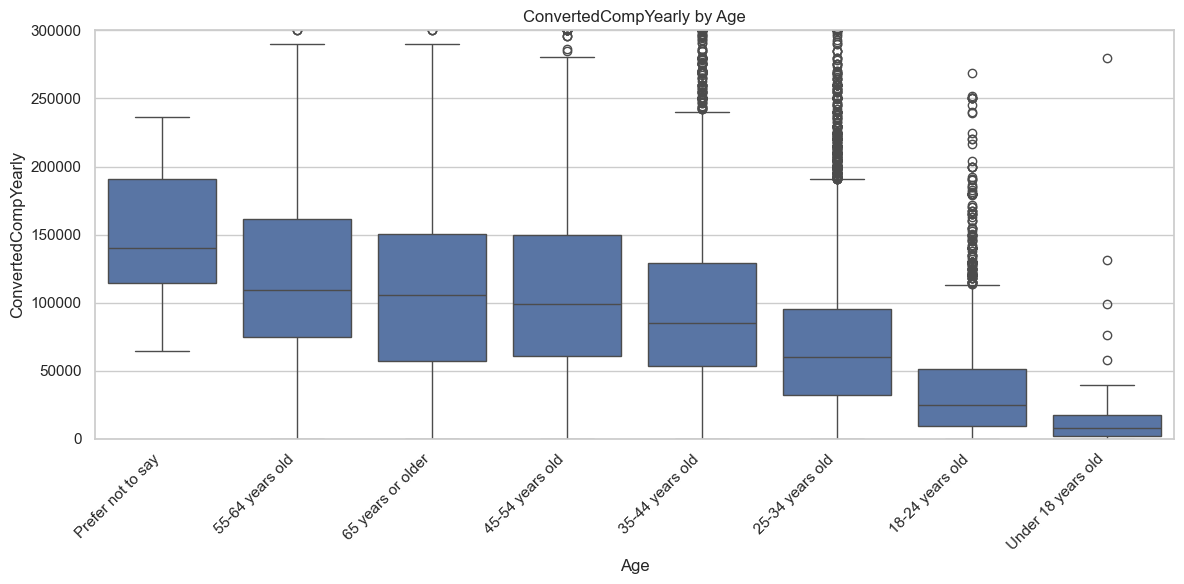

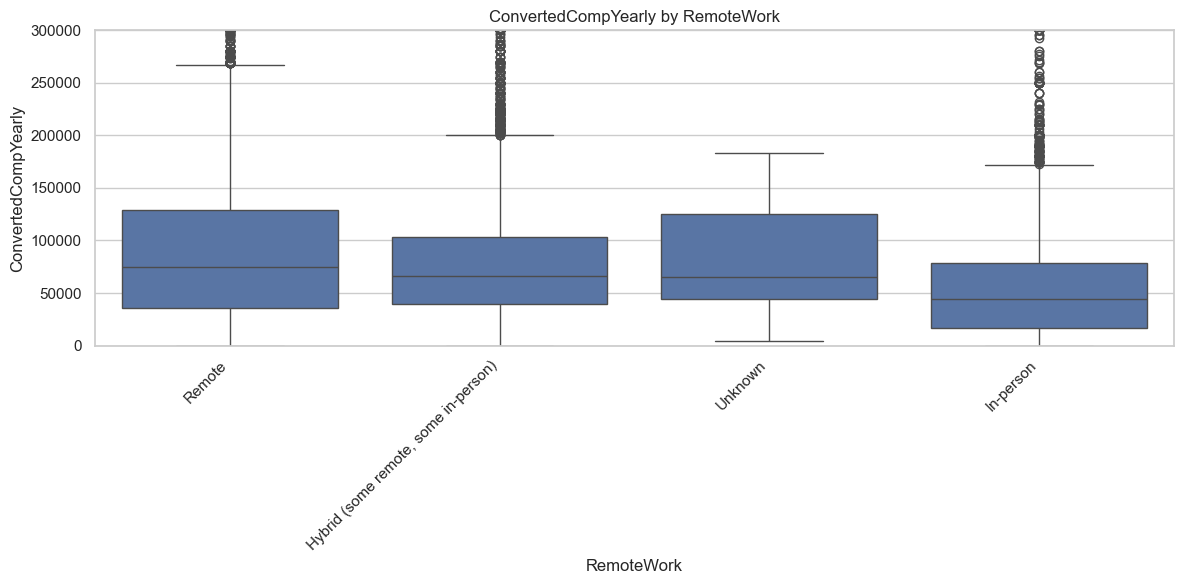

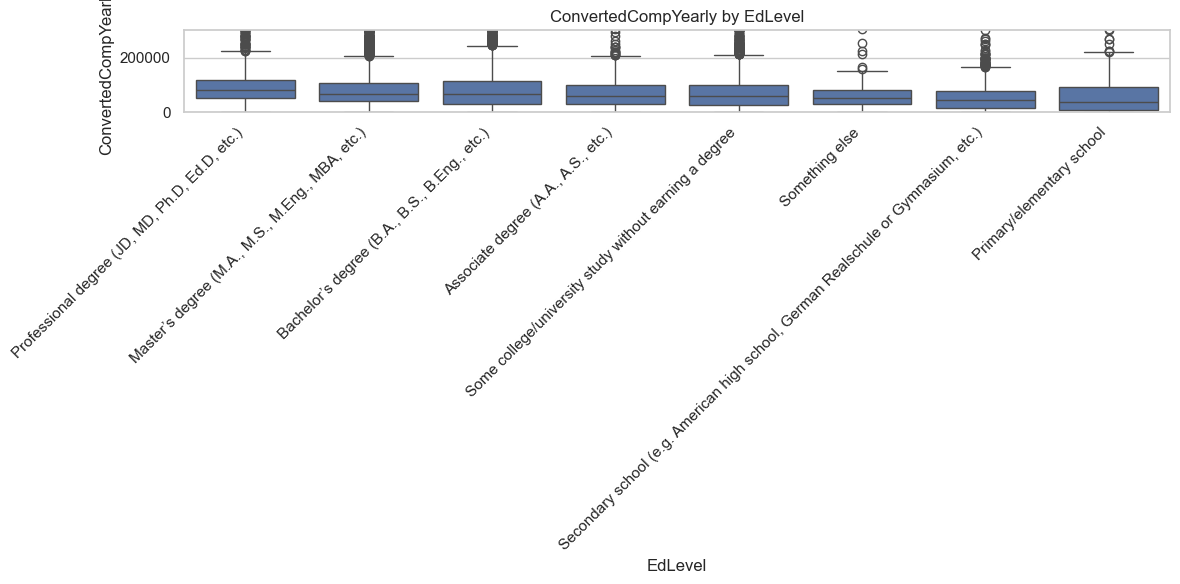


Showing Top 20 categories for YearsCode based on count.


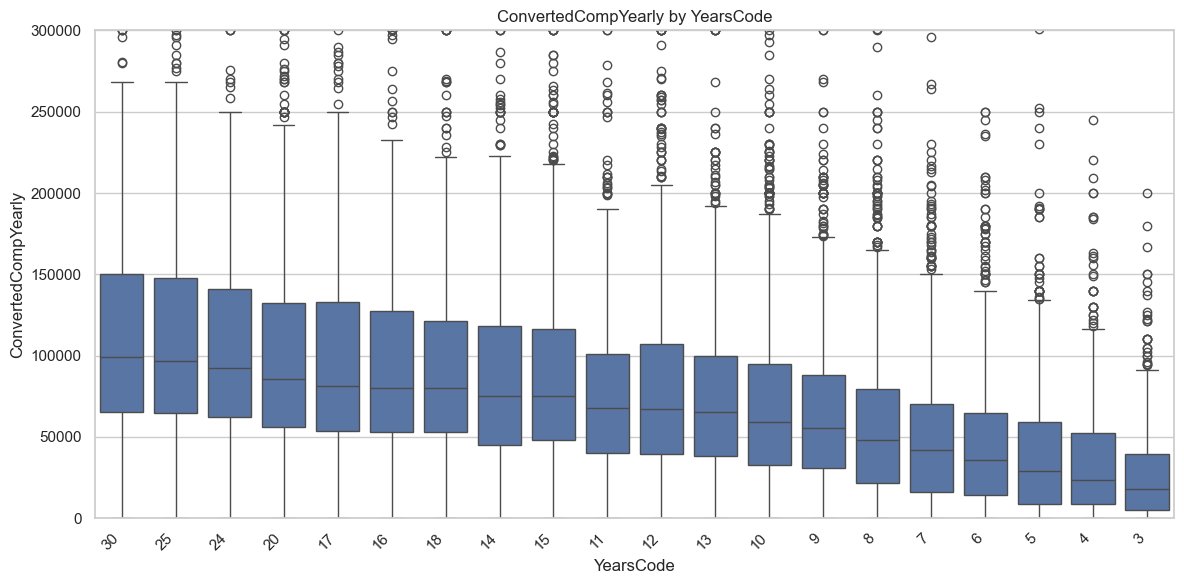


Showing Top 20 categories for YearsCodePro based on count.


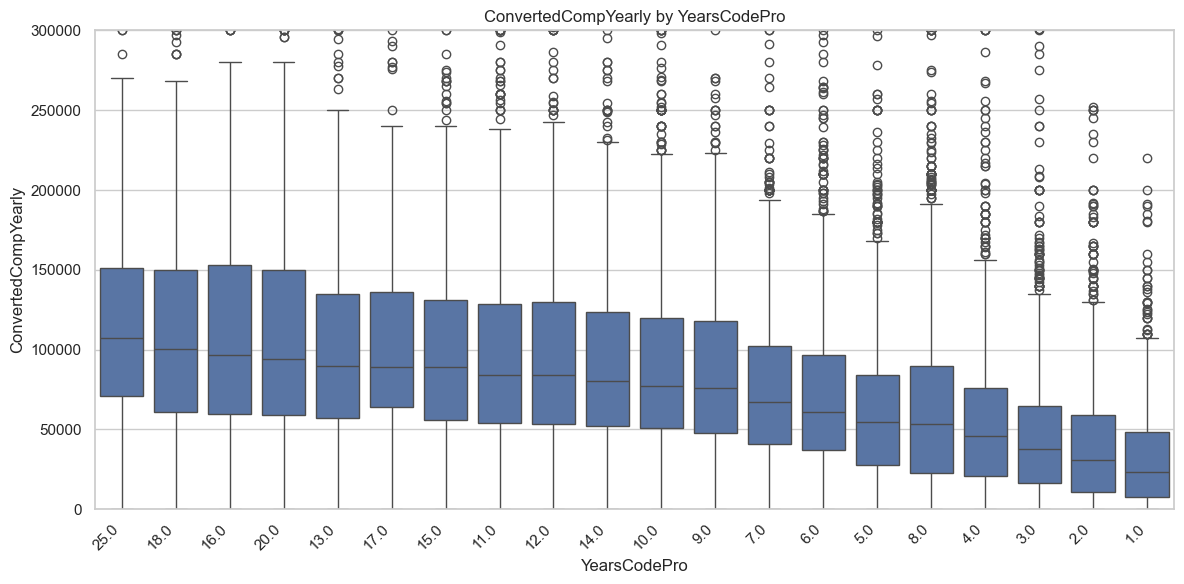


Showing Top 20 categories for DevType based on count.


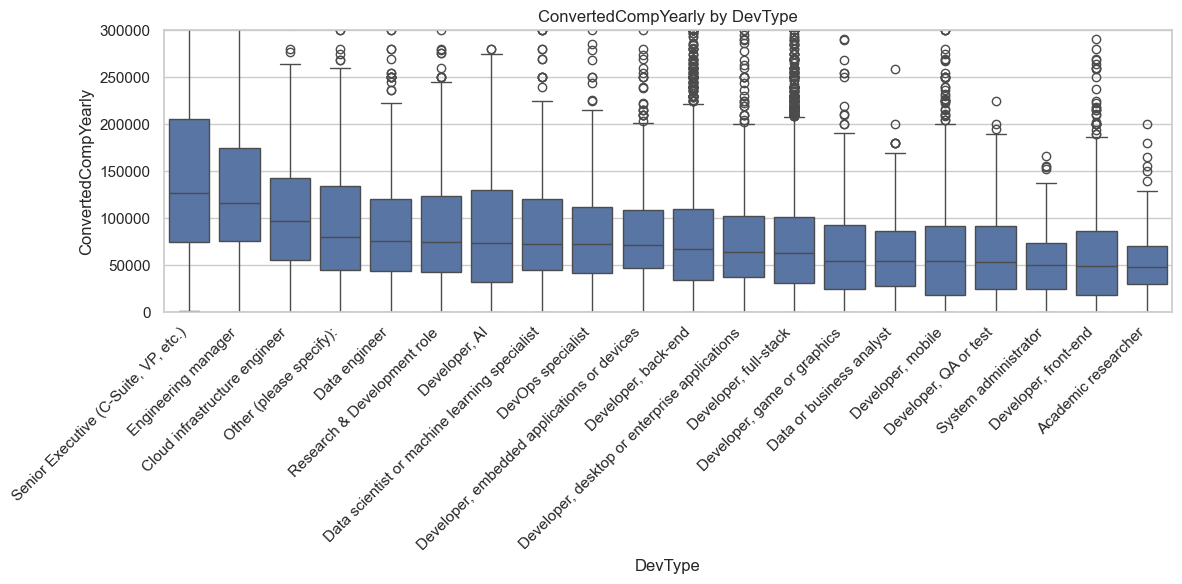

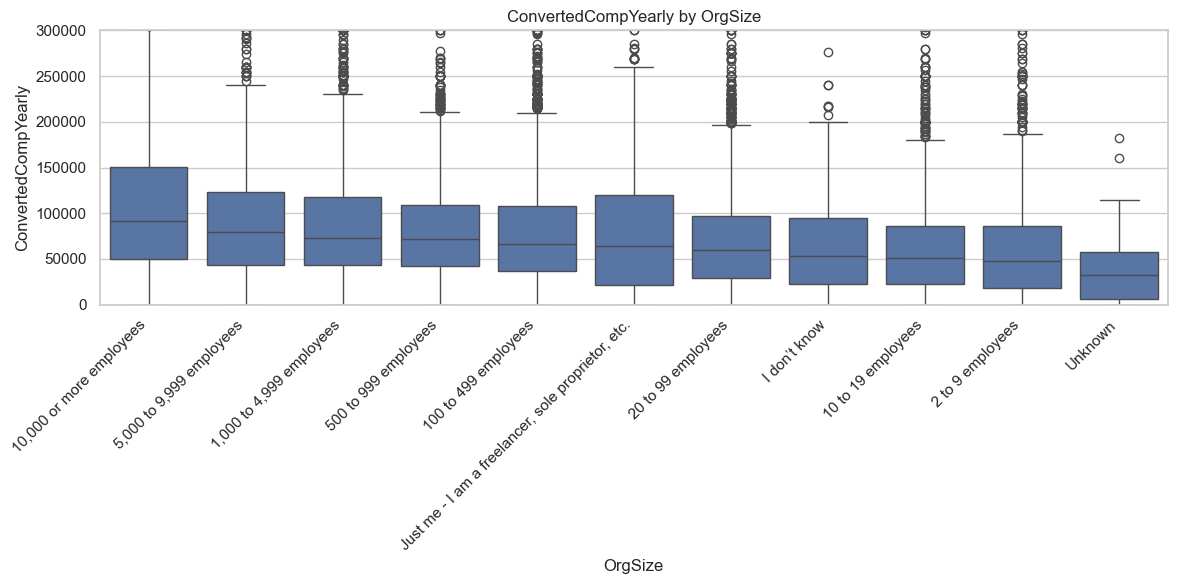

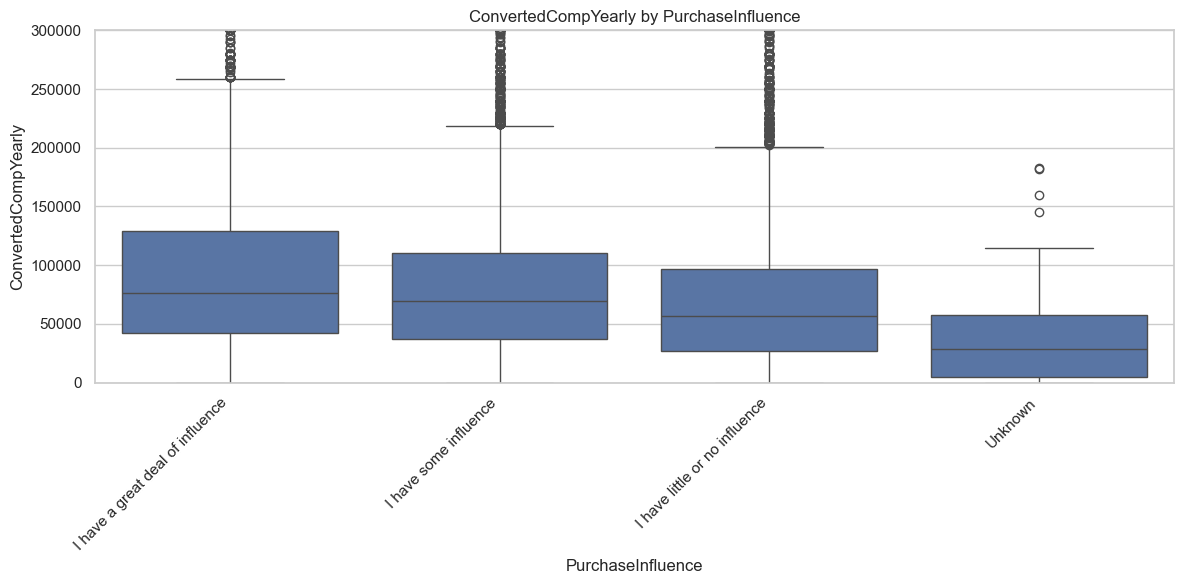

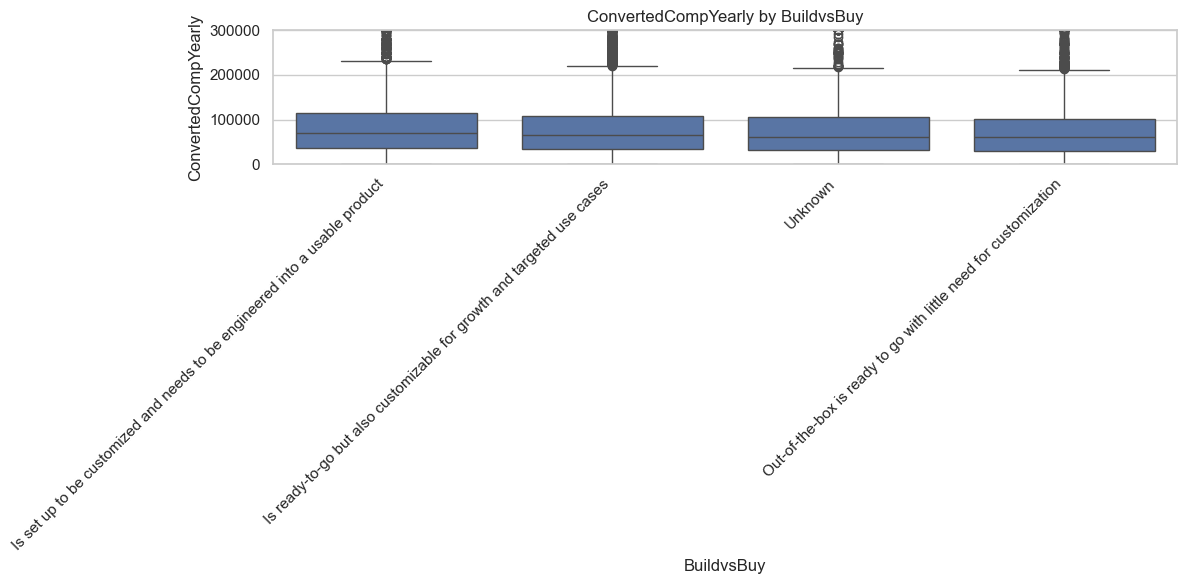


Showing Top 20 categories for NEWSOSites based on count.


/var/folders/f2/gclmb9nd72sdmdcwwfjp4y3c0000gn/T/ipykernel_10846/3069197500.py:84: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



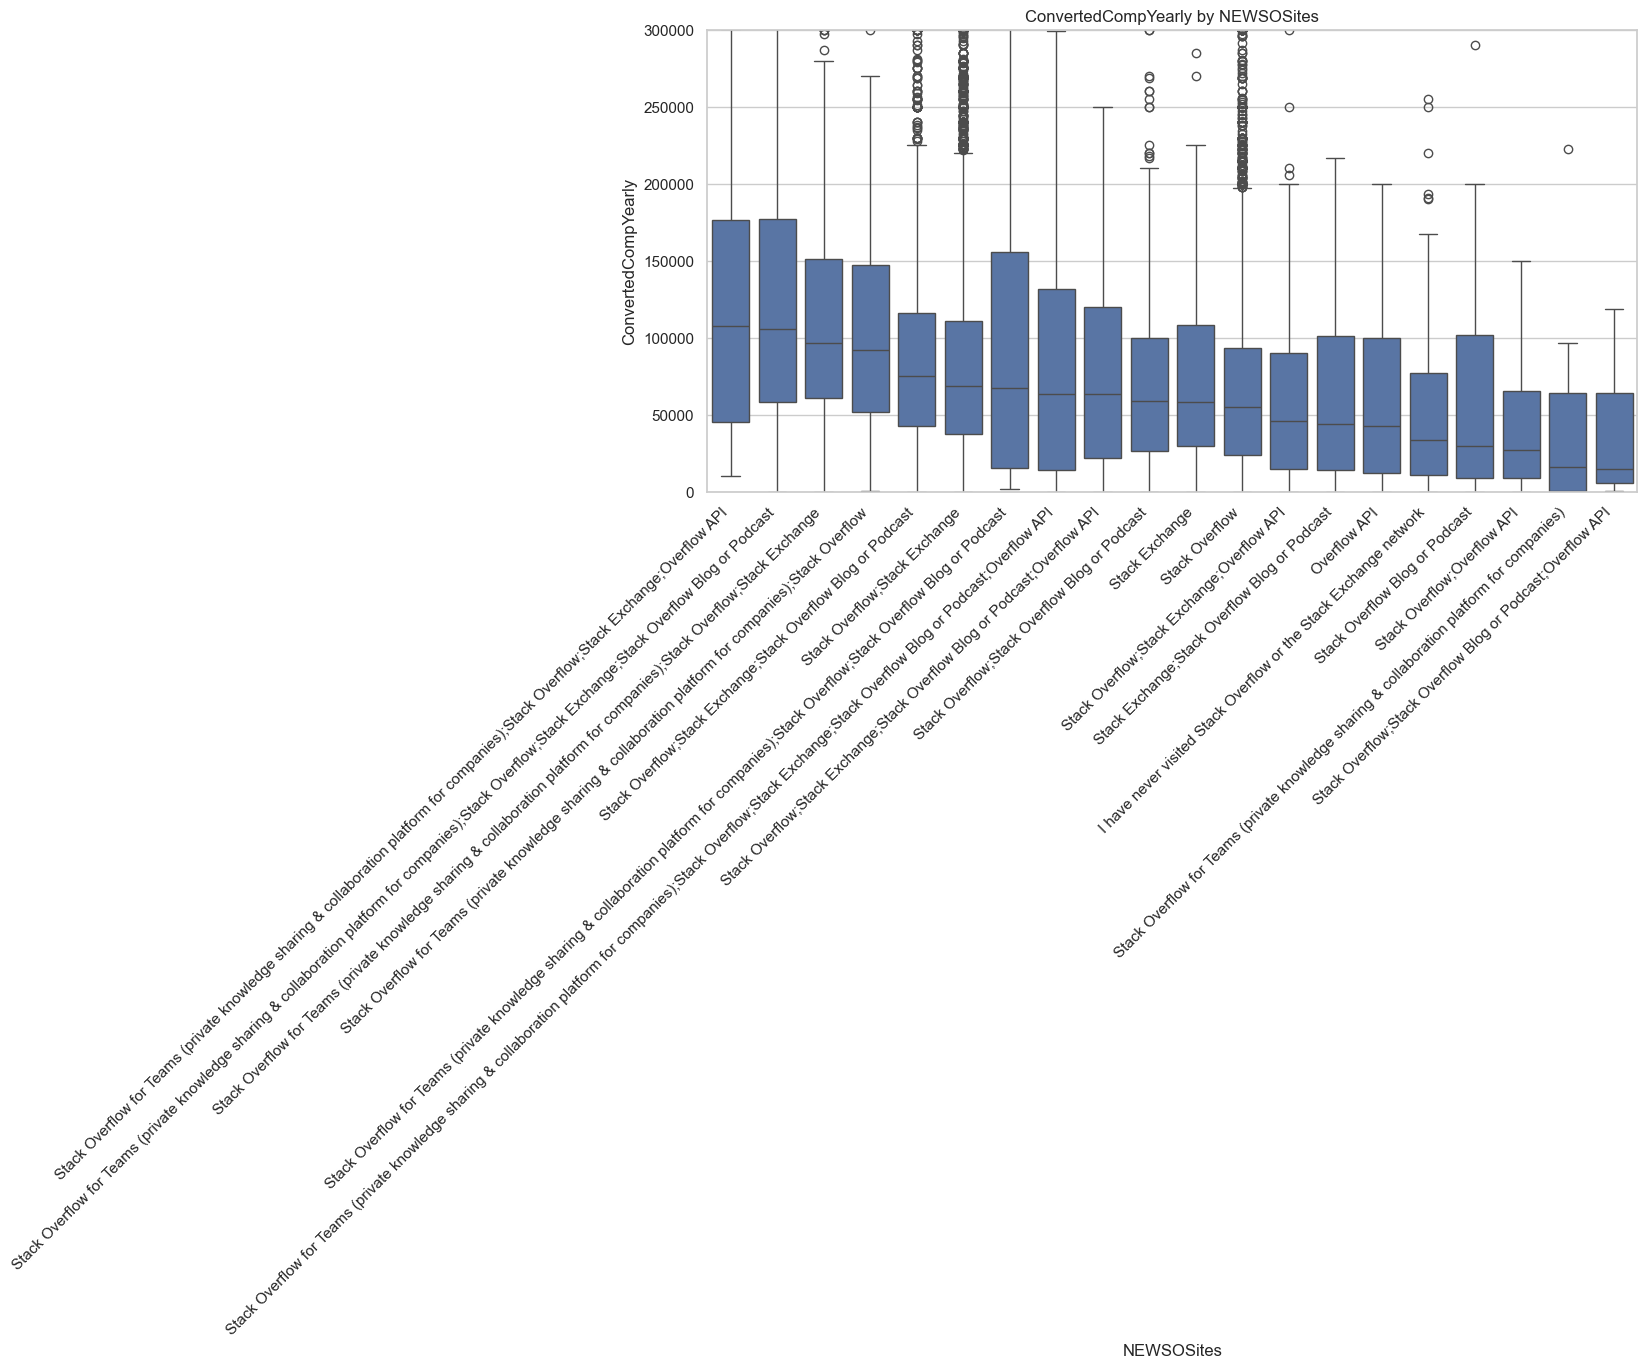

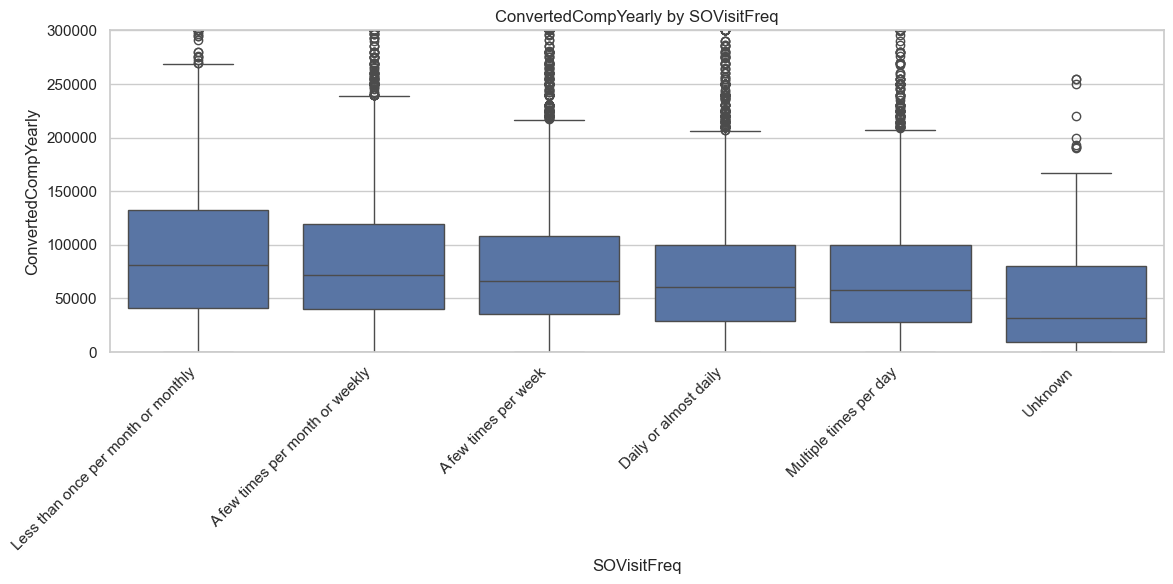

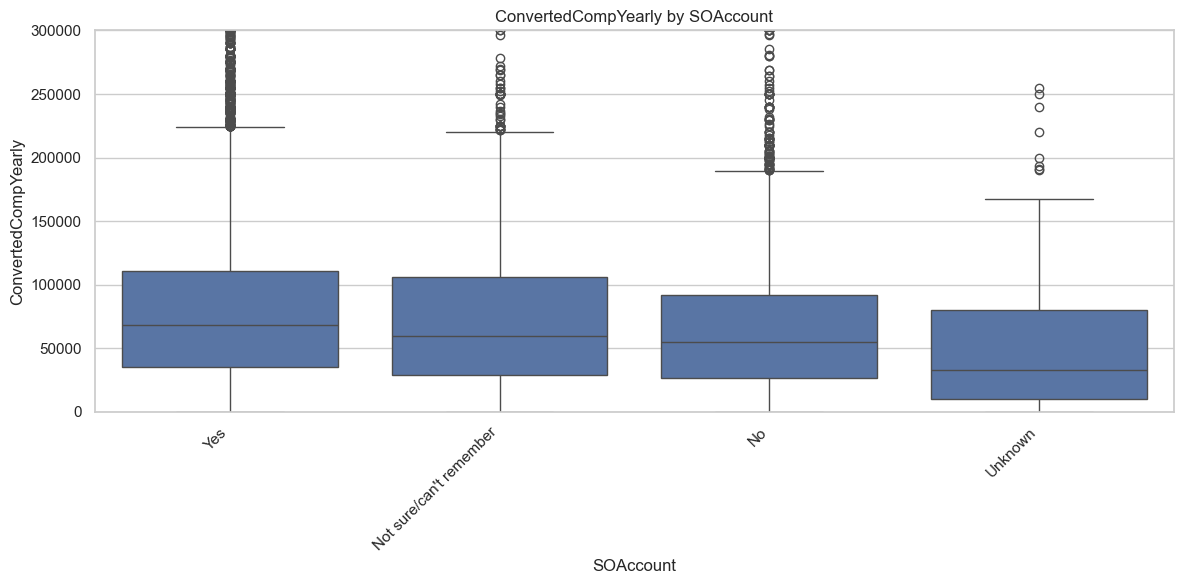

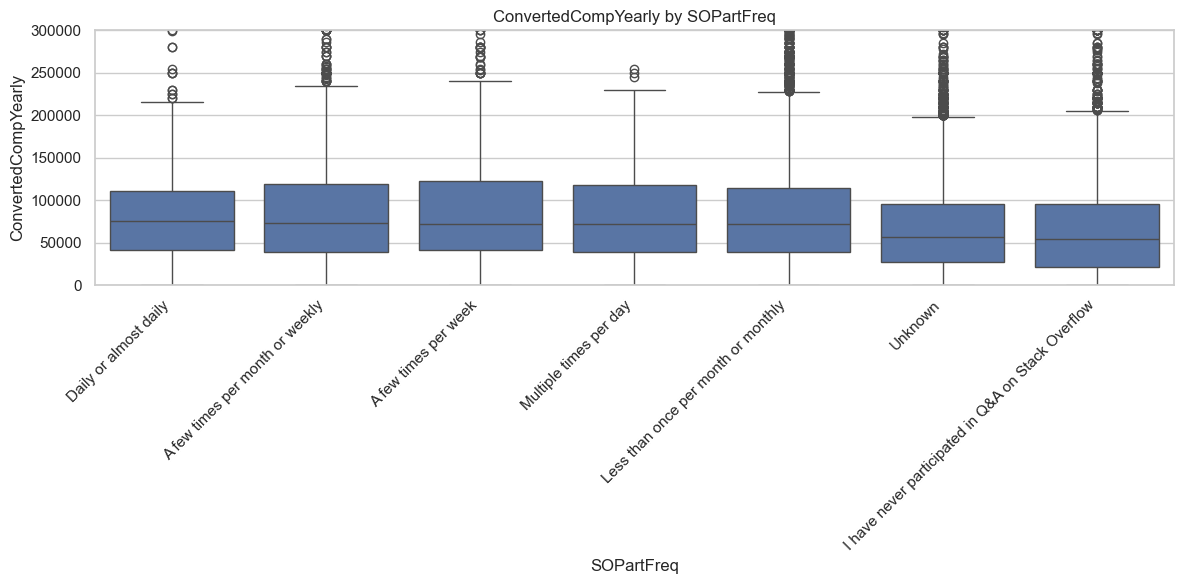

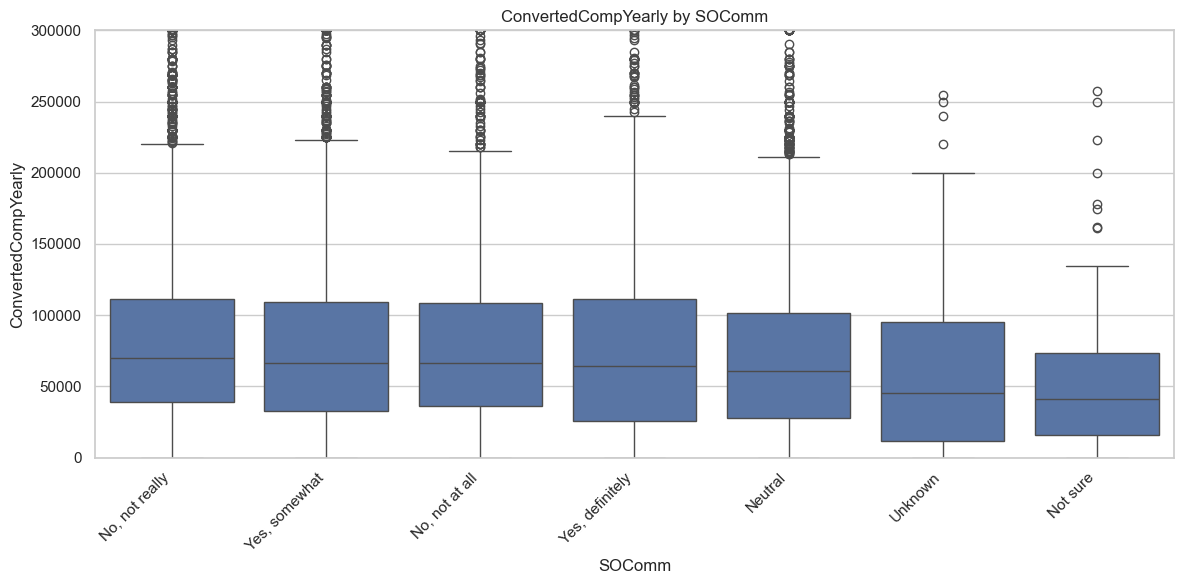

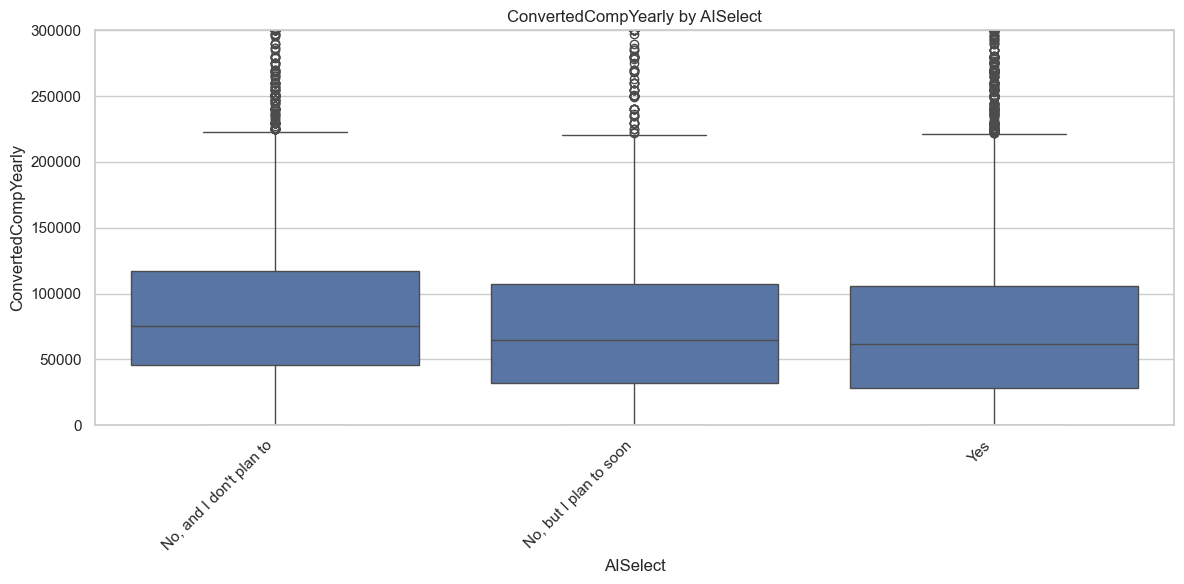

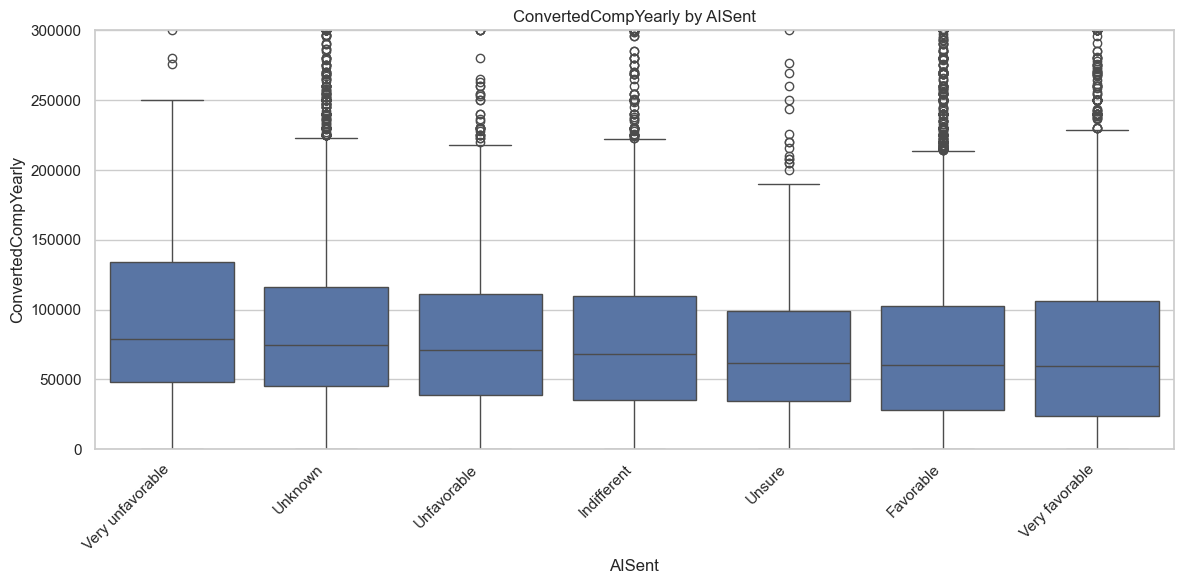

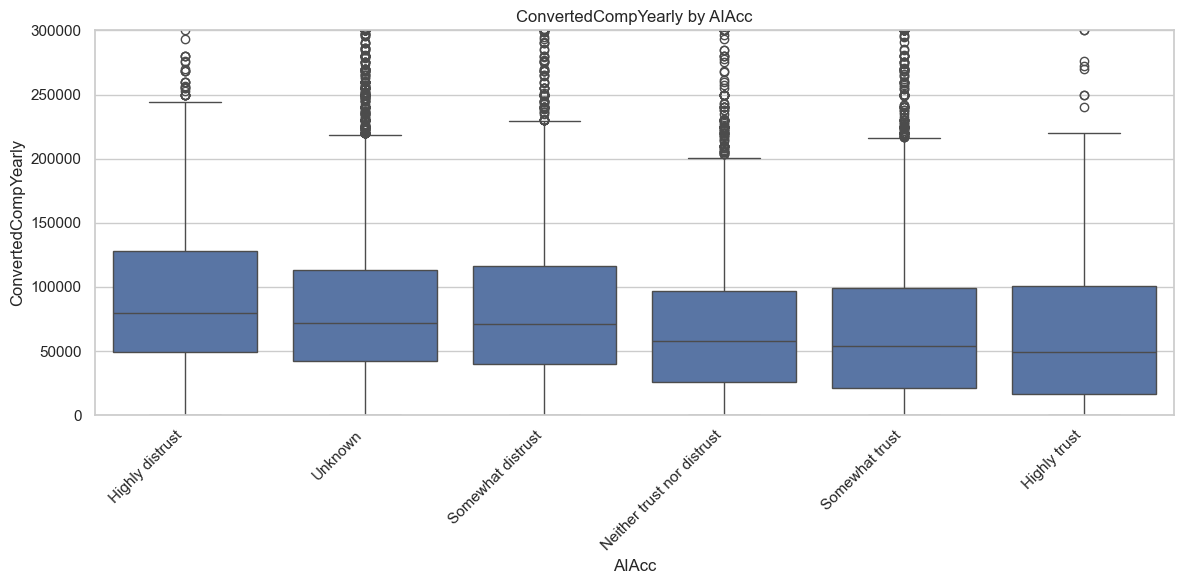

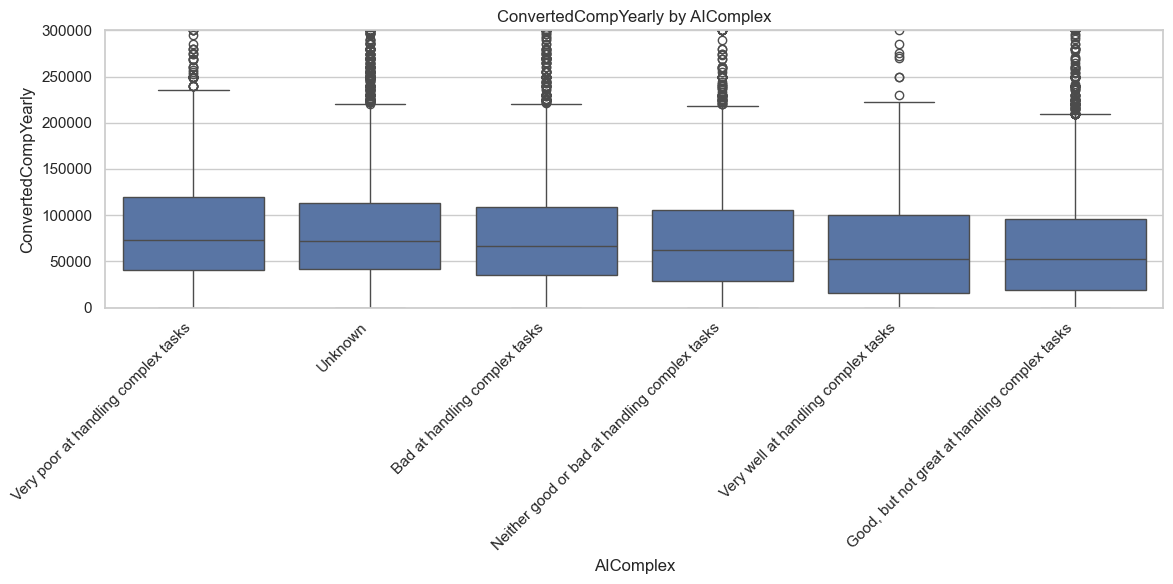

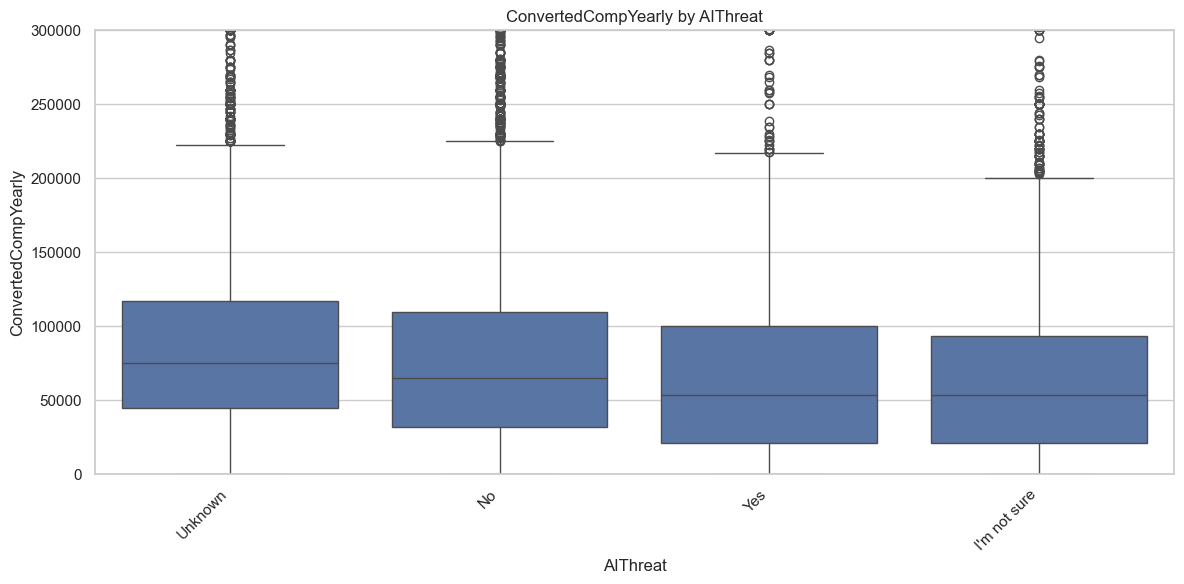

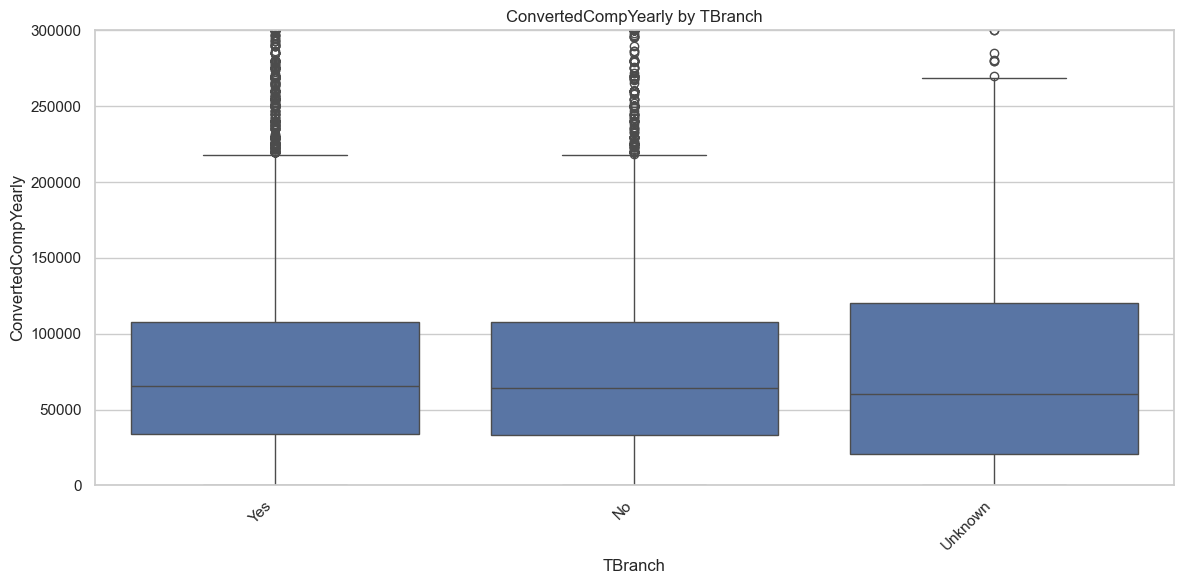

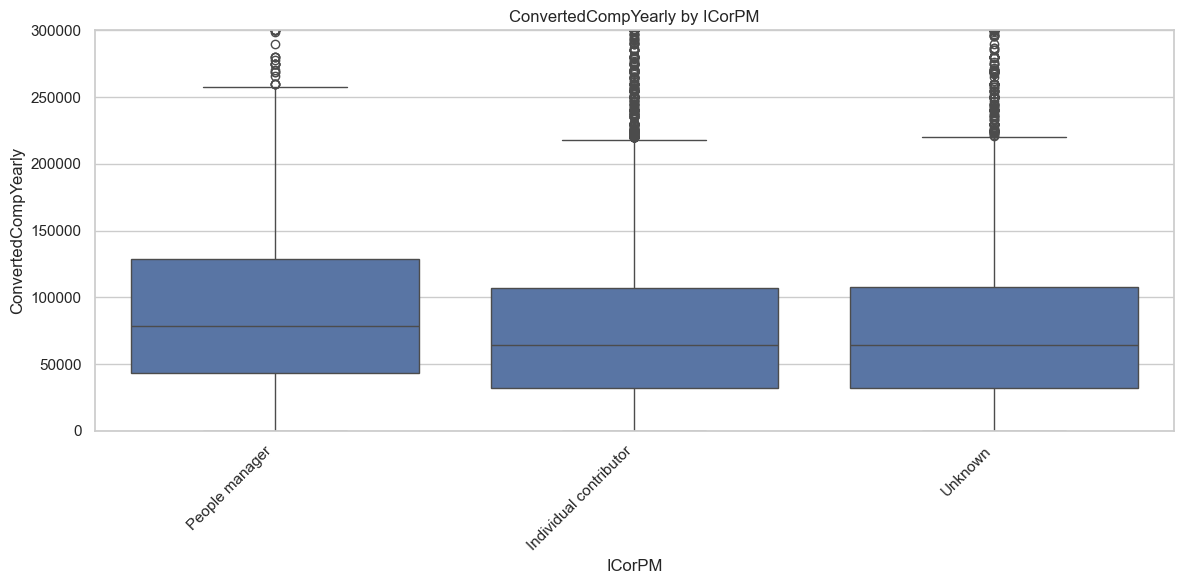

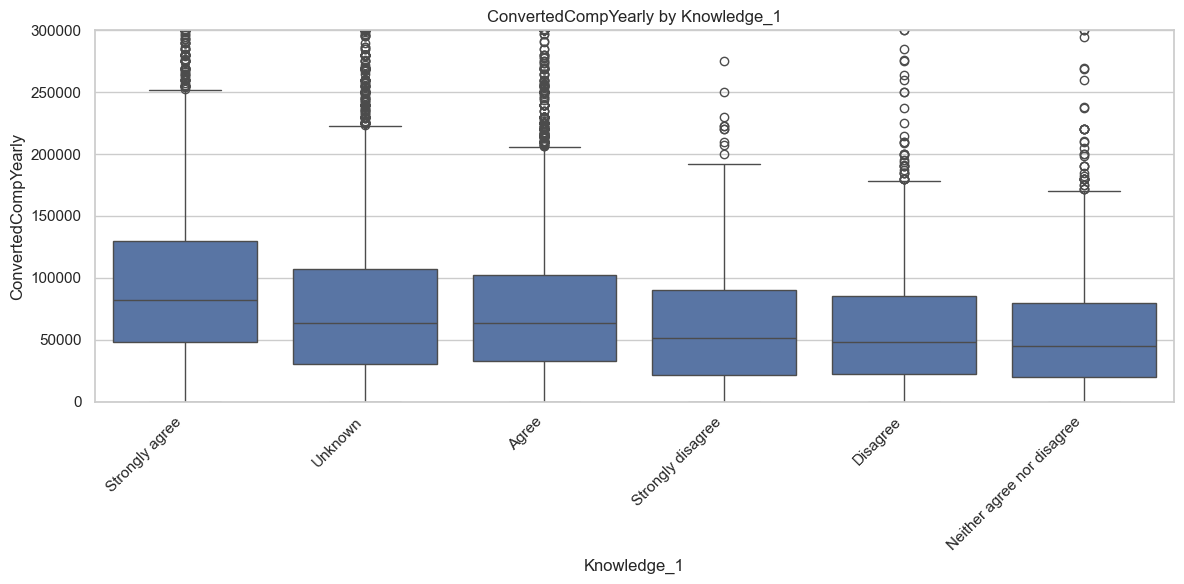

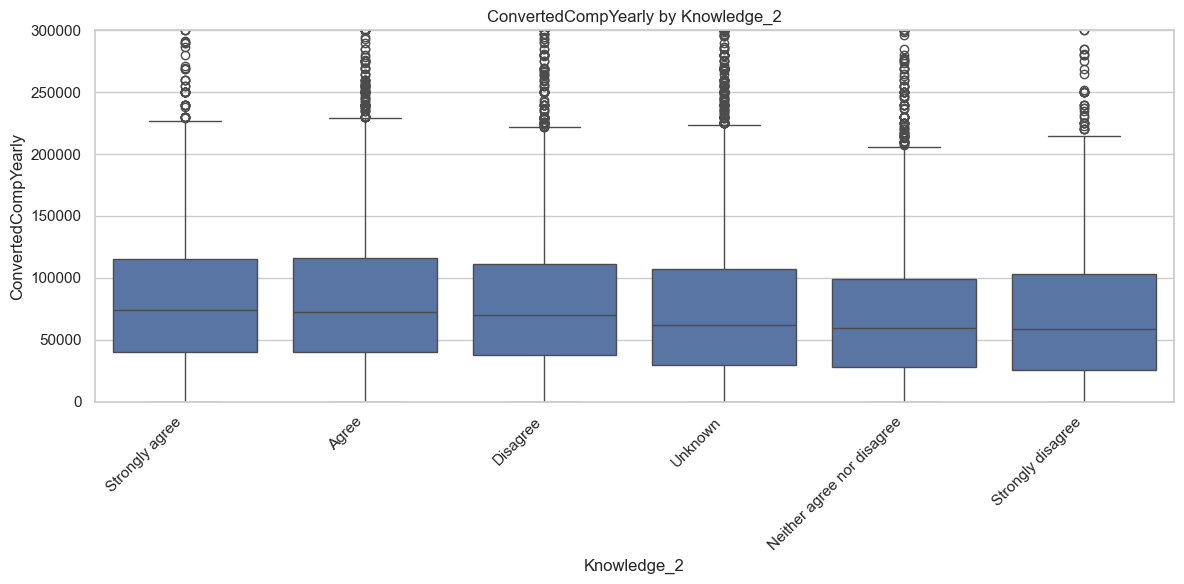

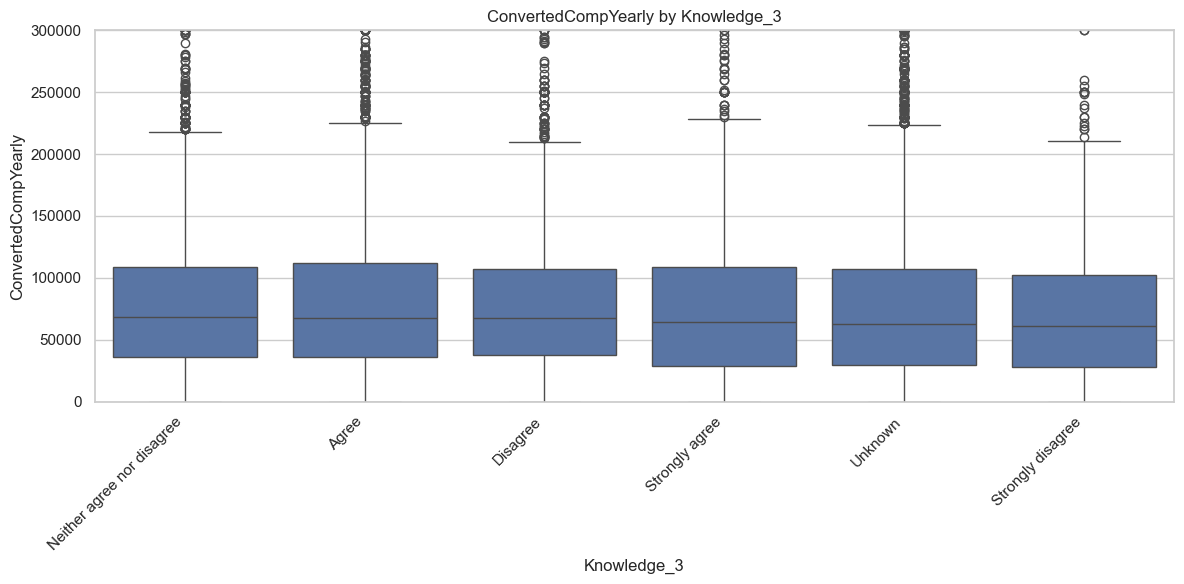

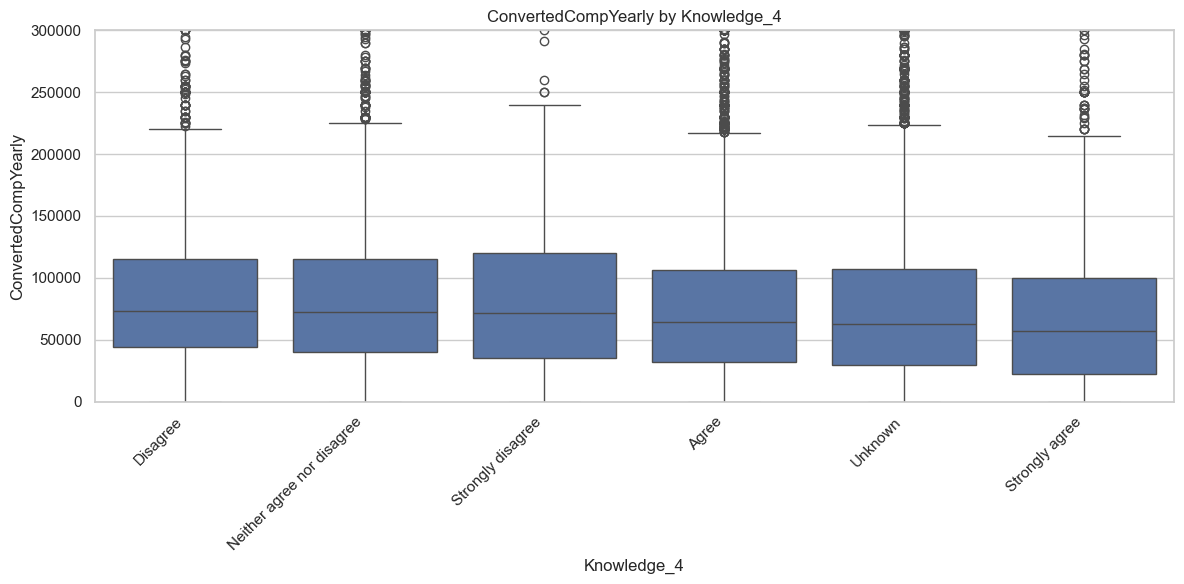

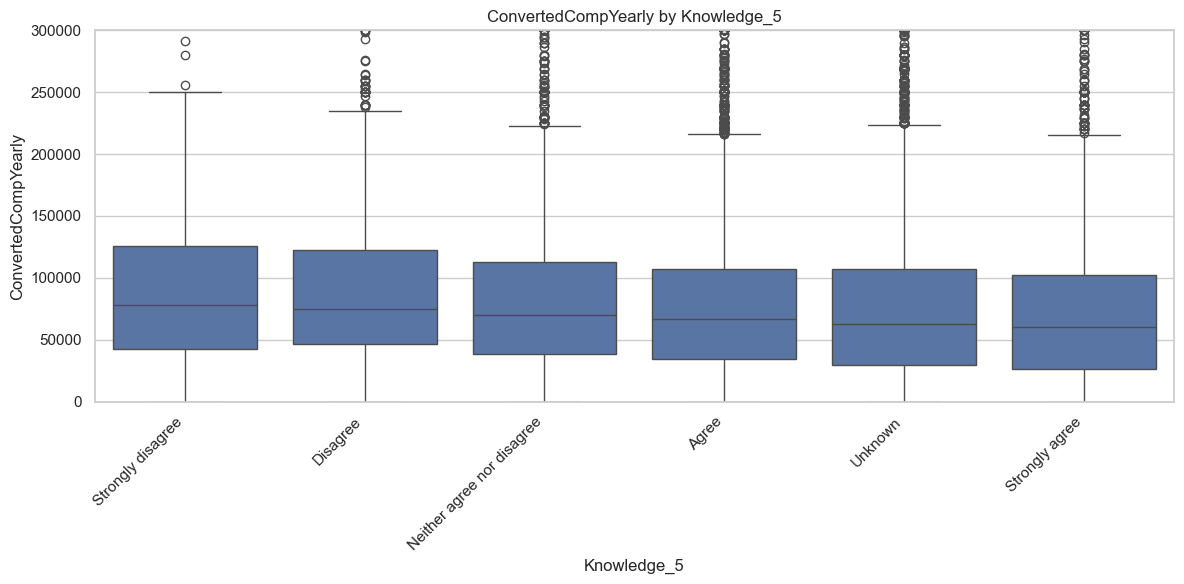

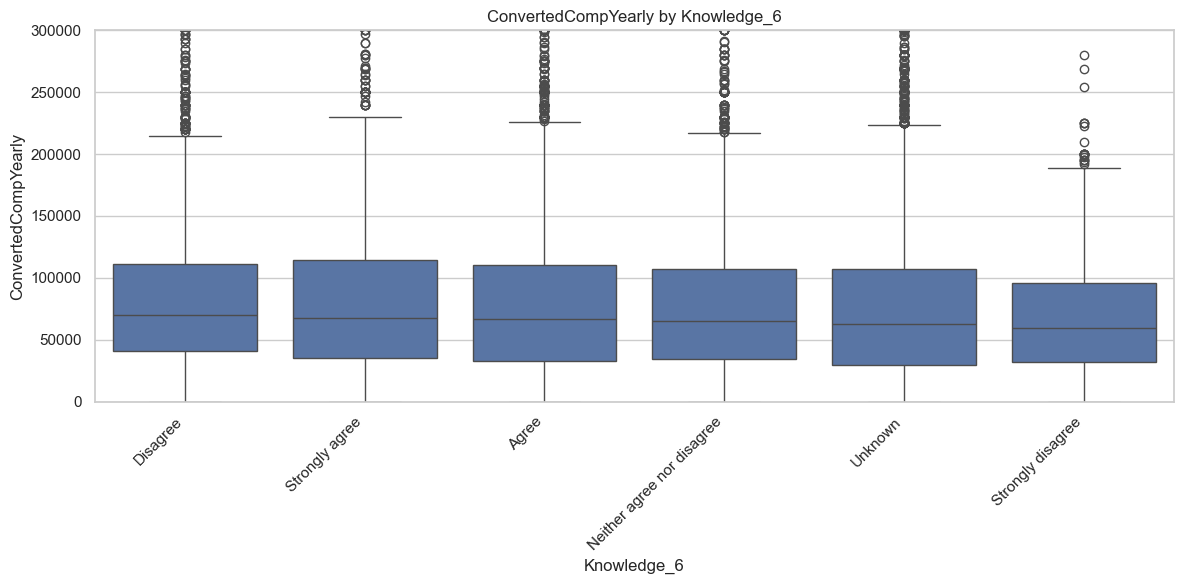

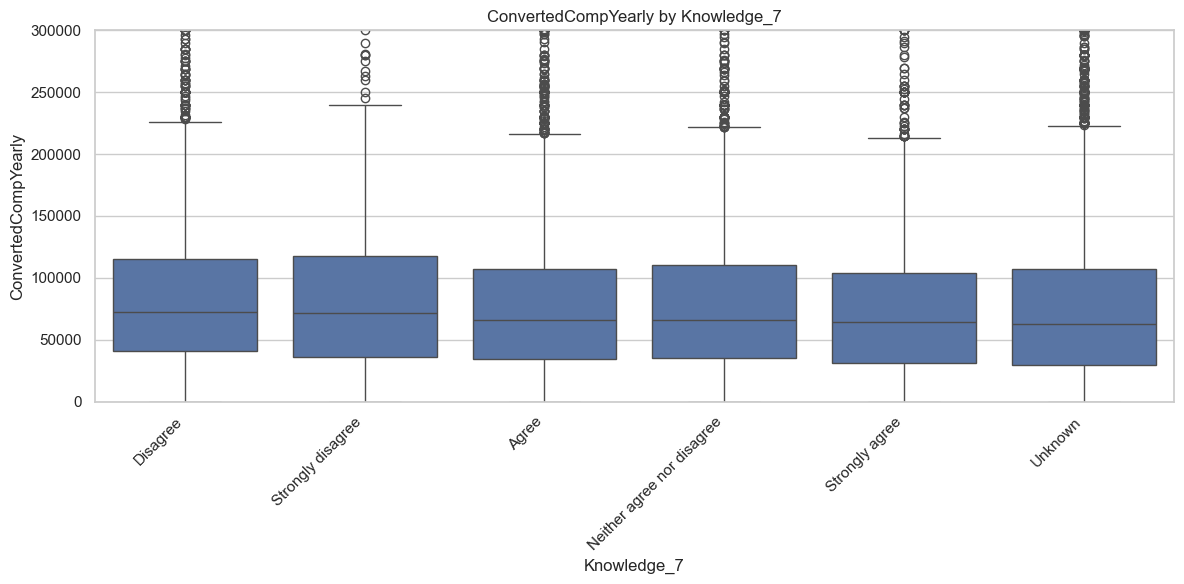

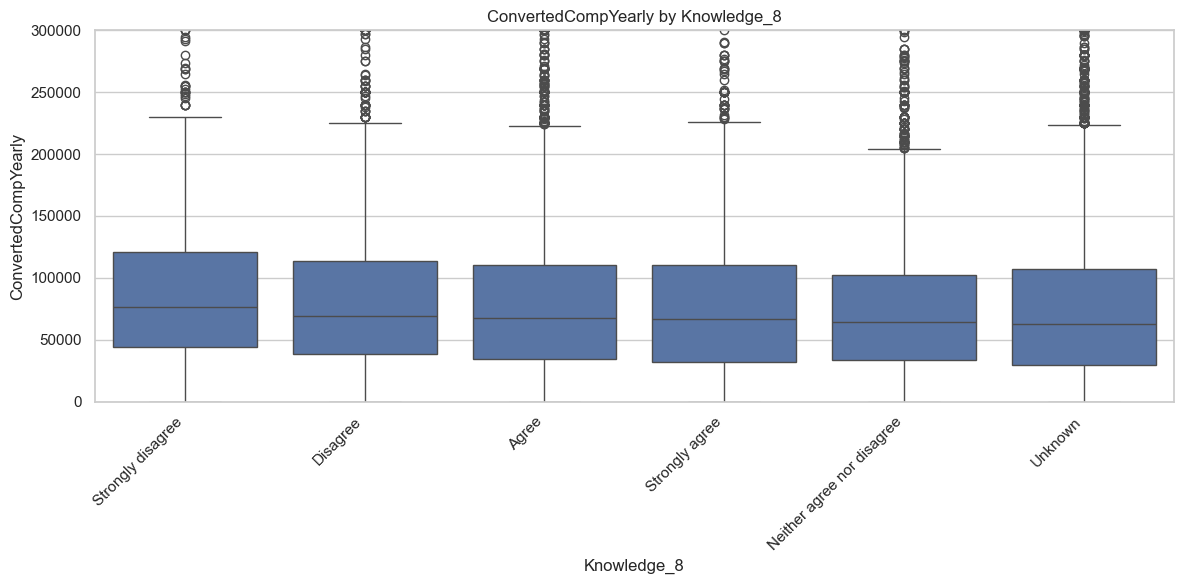

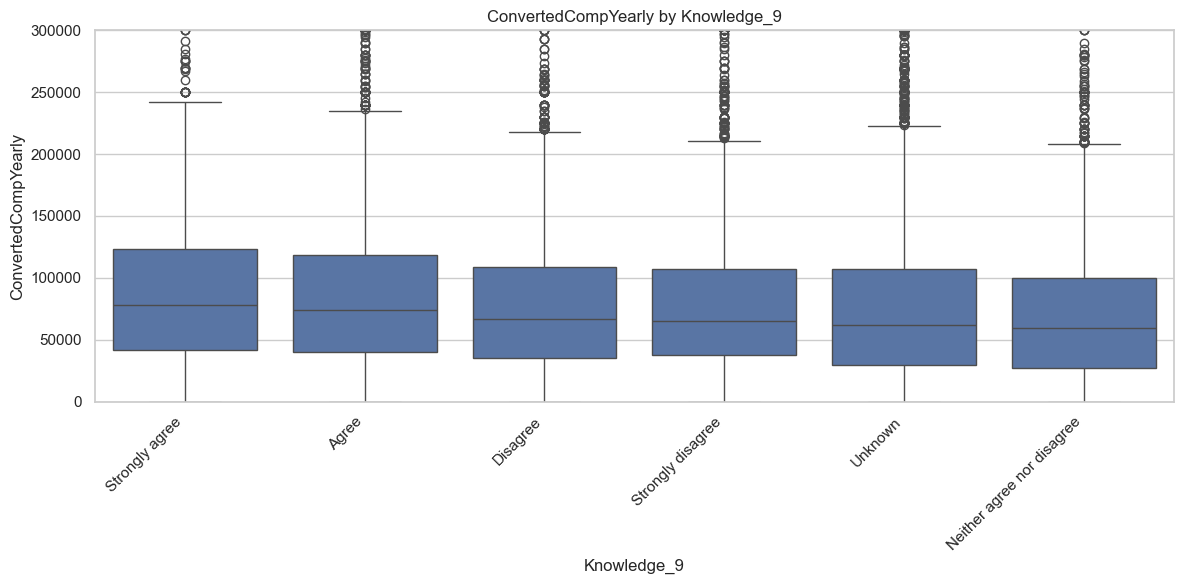

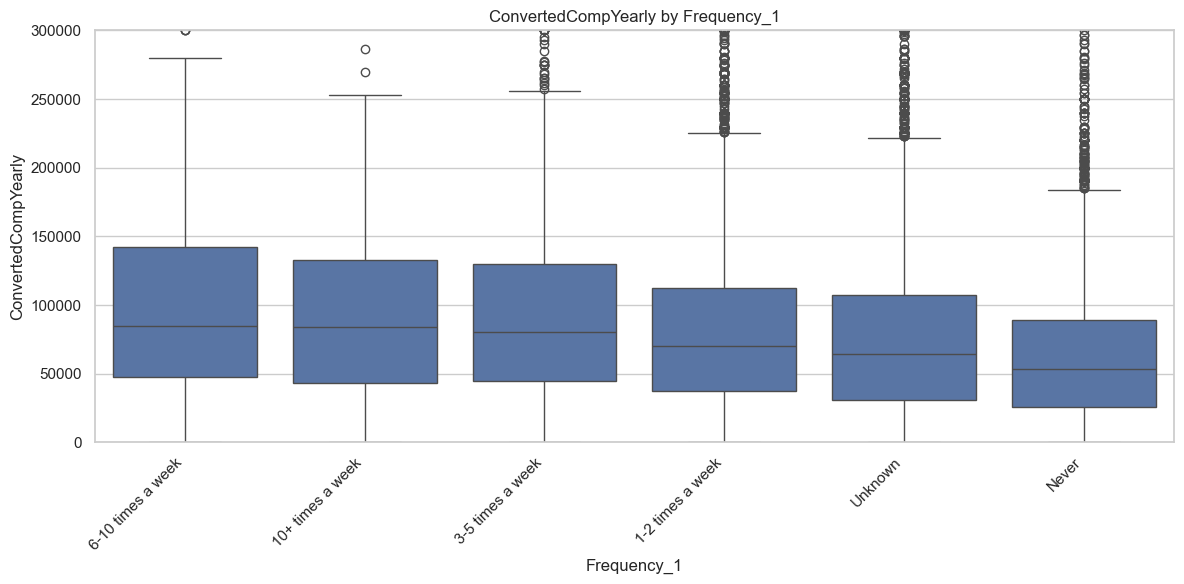

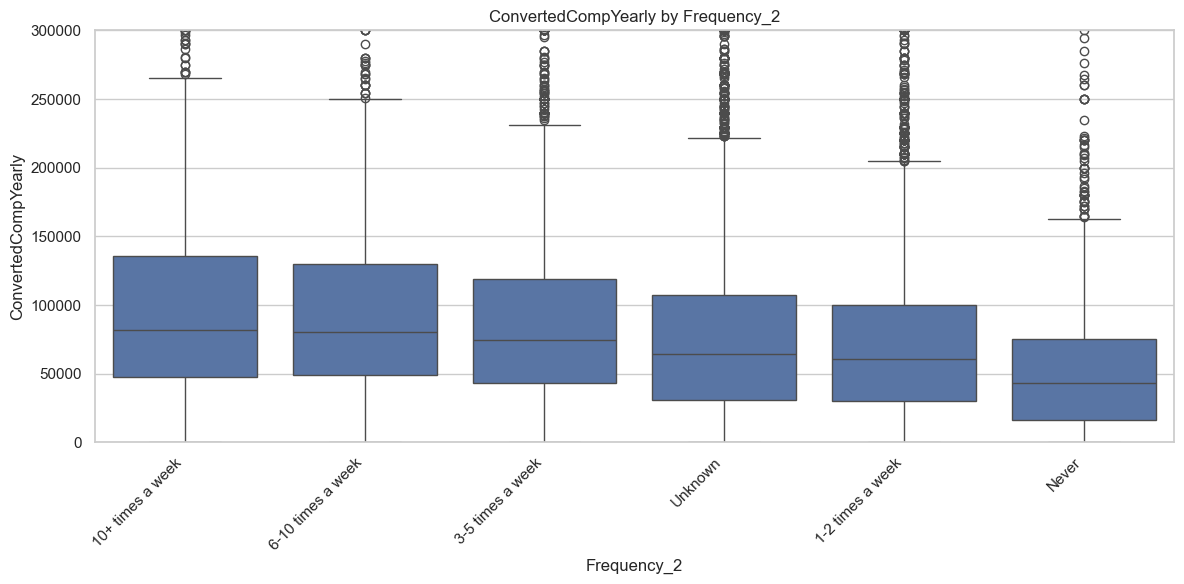

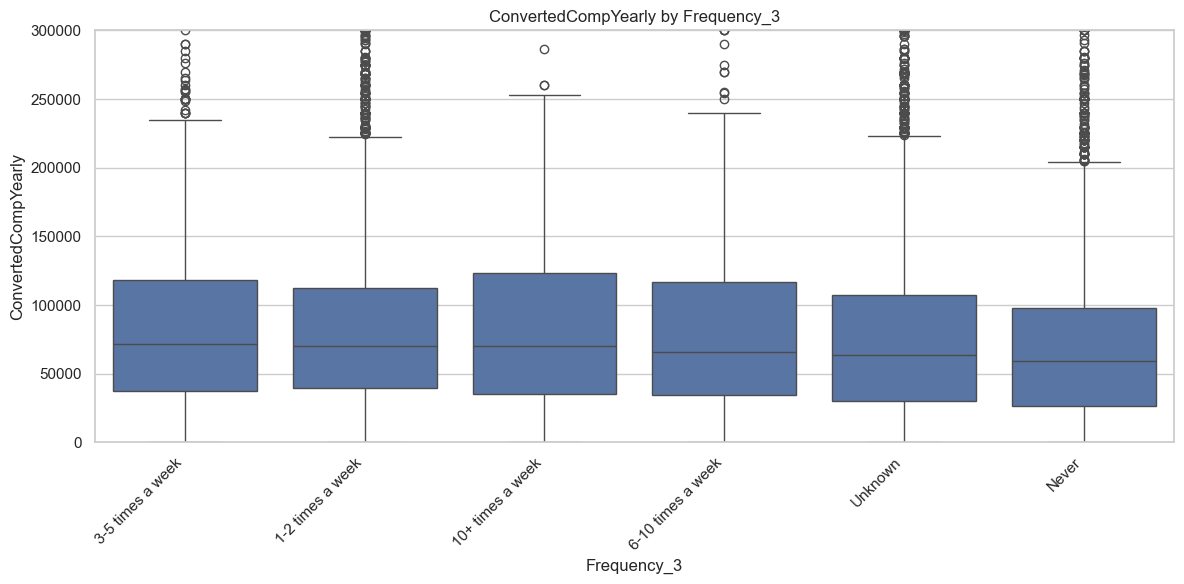

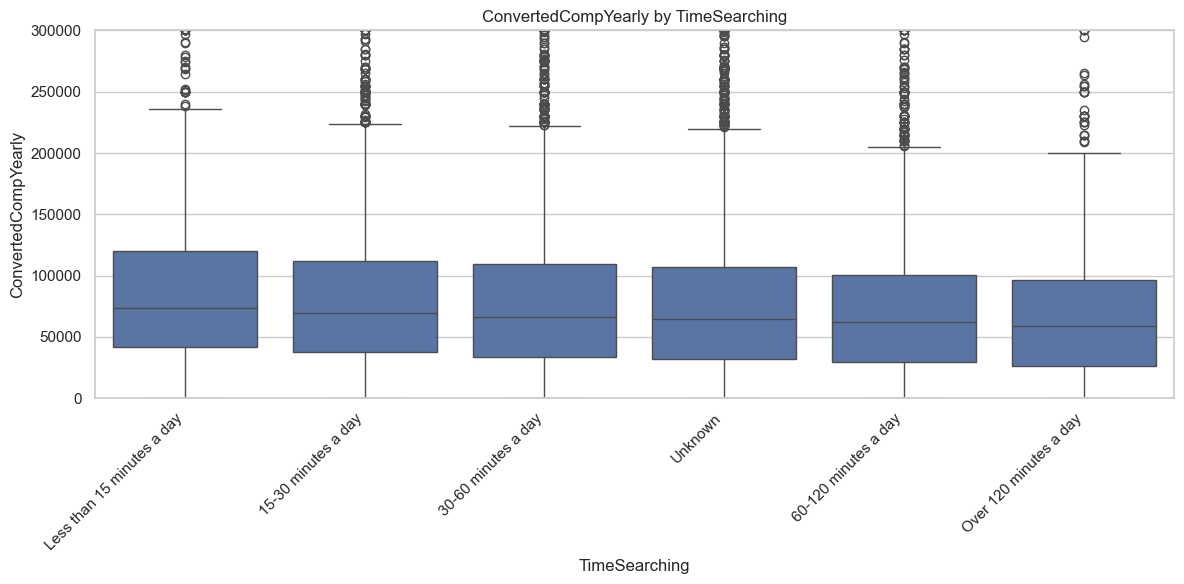

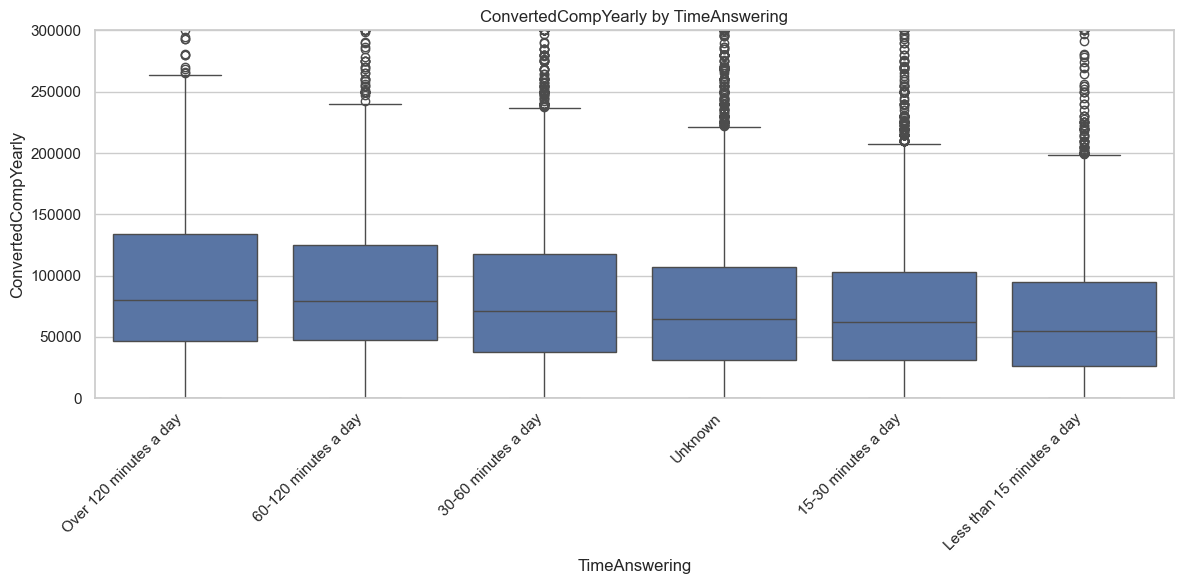

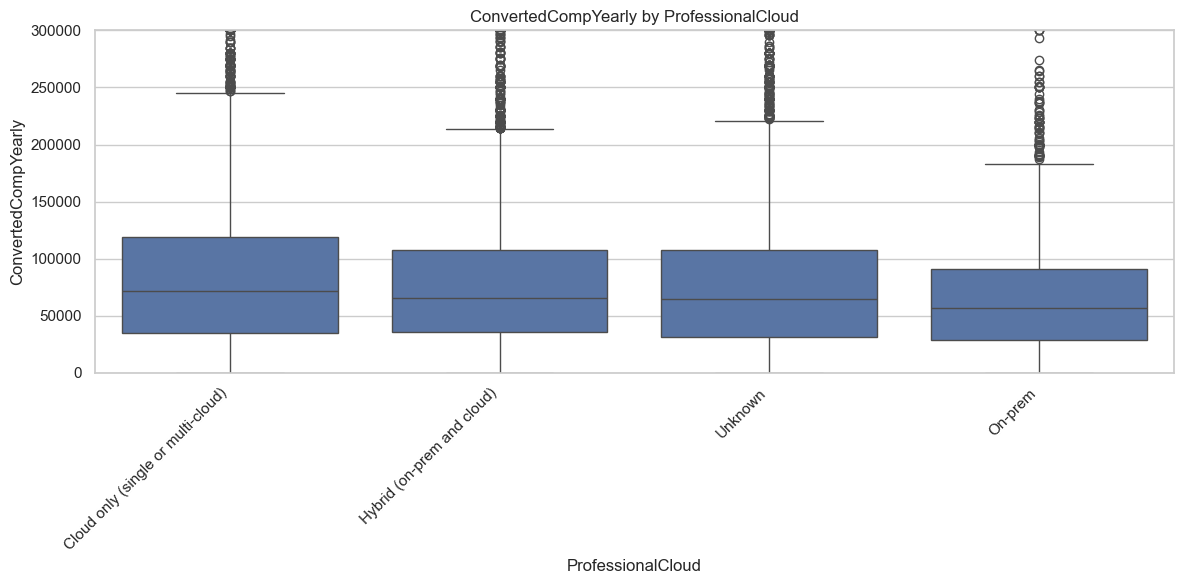

/var/folders/f2/gclmb9nd72sdmdcwwfjp4y3c0000gn/T/ipykernel_10846/3069197500.py:84: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



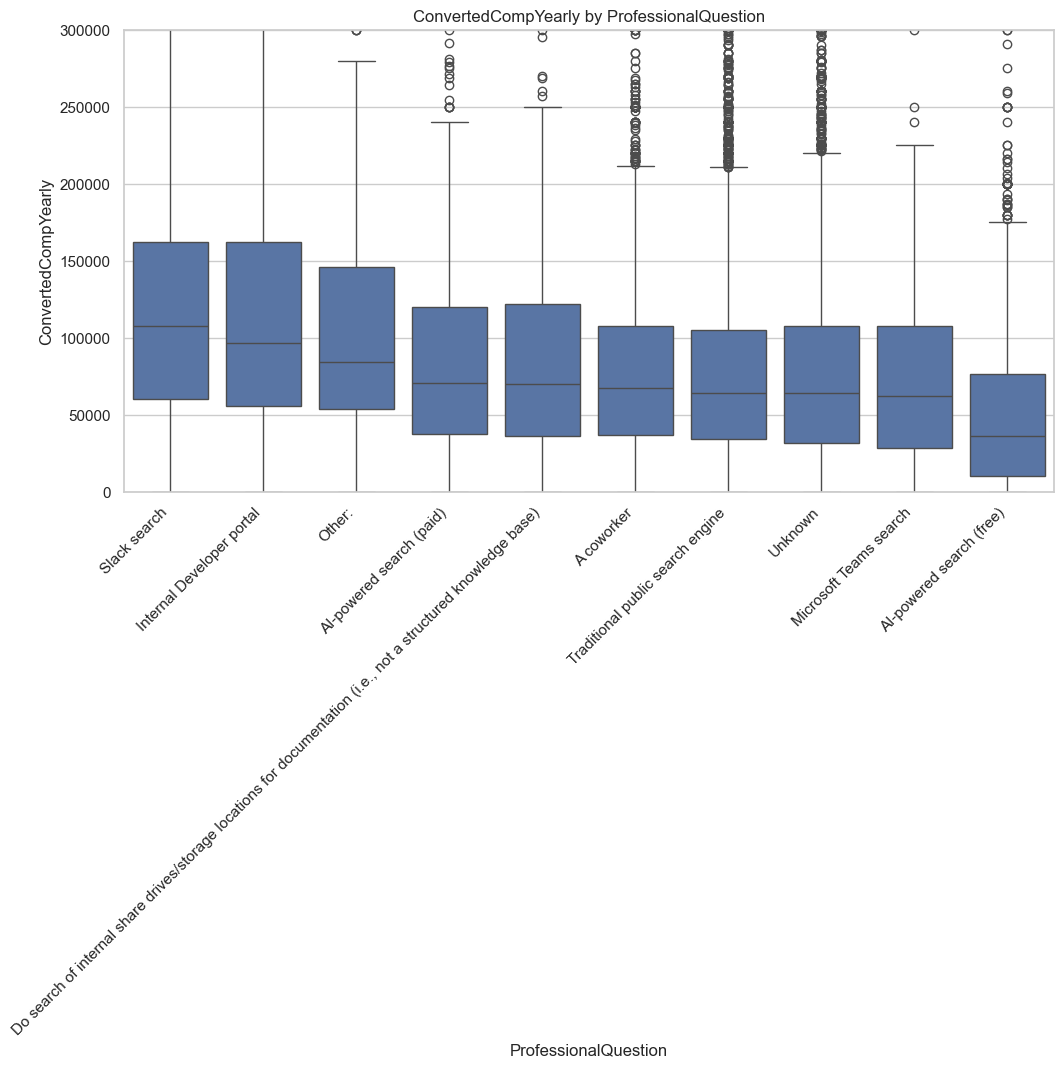

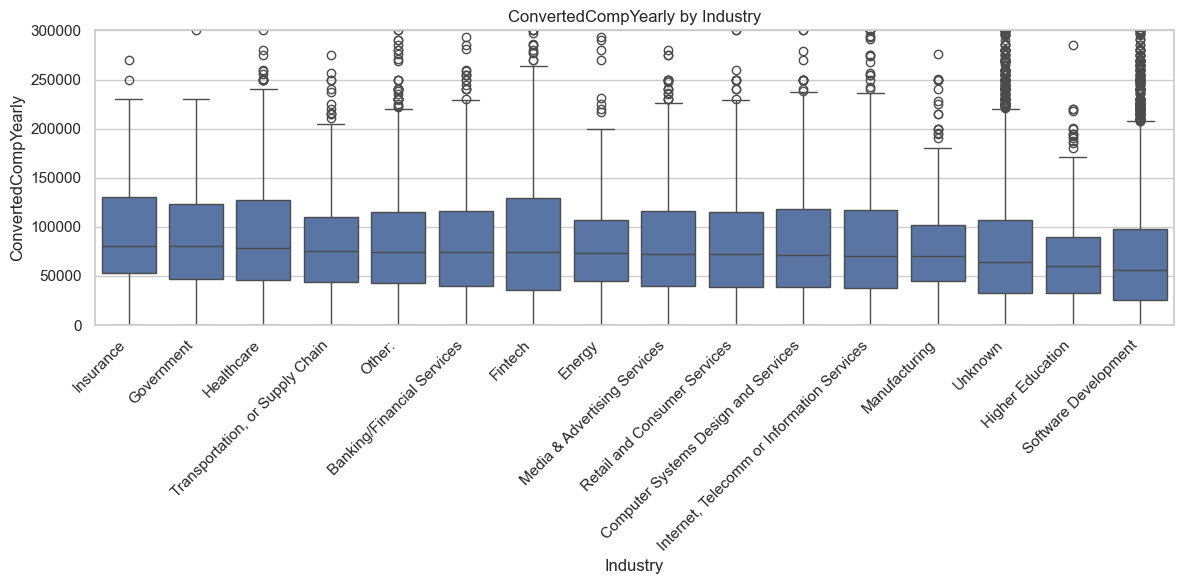


Showing Top 20 categories for Country based on count.


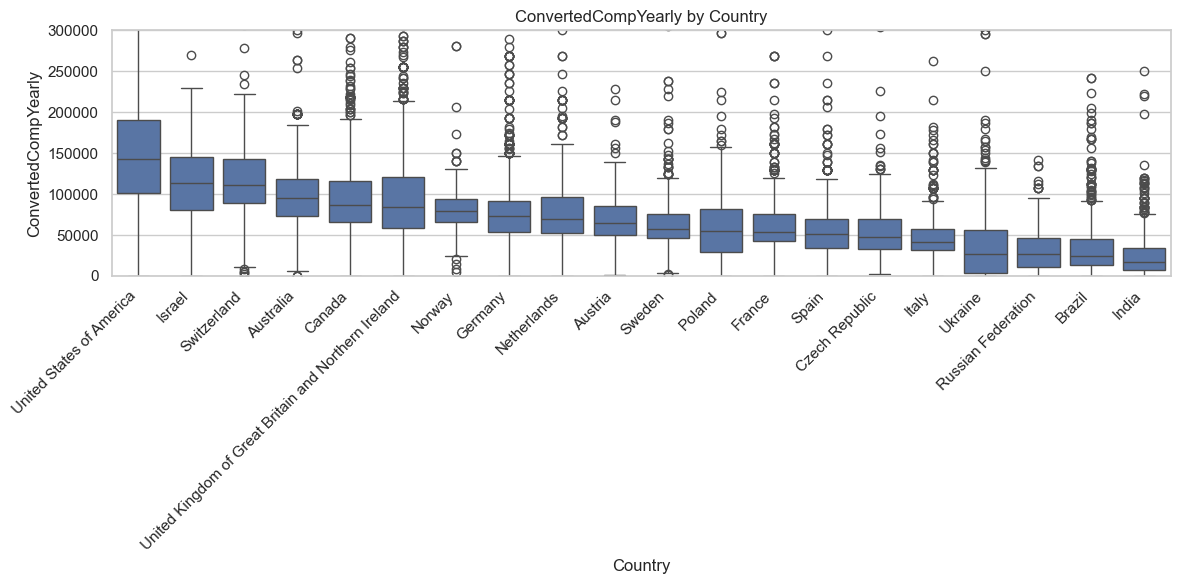


Showing Top 20 categories for Employment based on count.


/var/folders/f2/gclmb9nd72sdmdcwwfjp4y3c0000gn/T/ipykernel_10846/3069197500.py:84: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



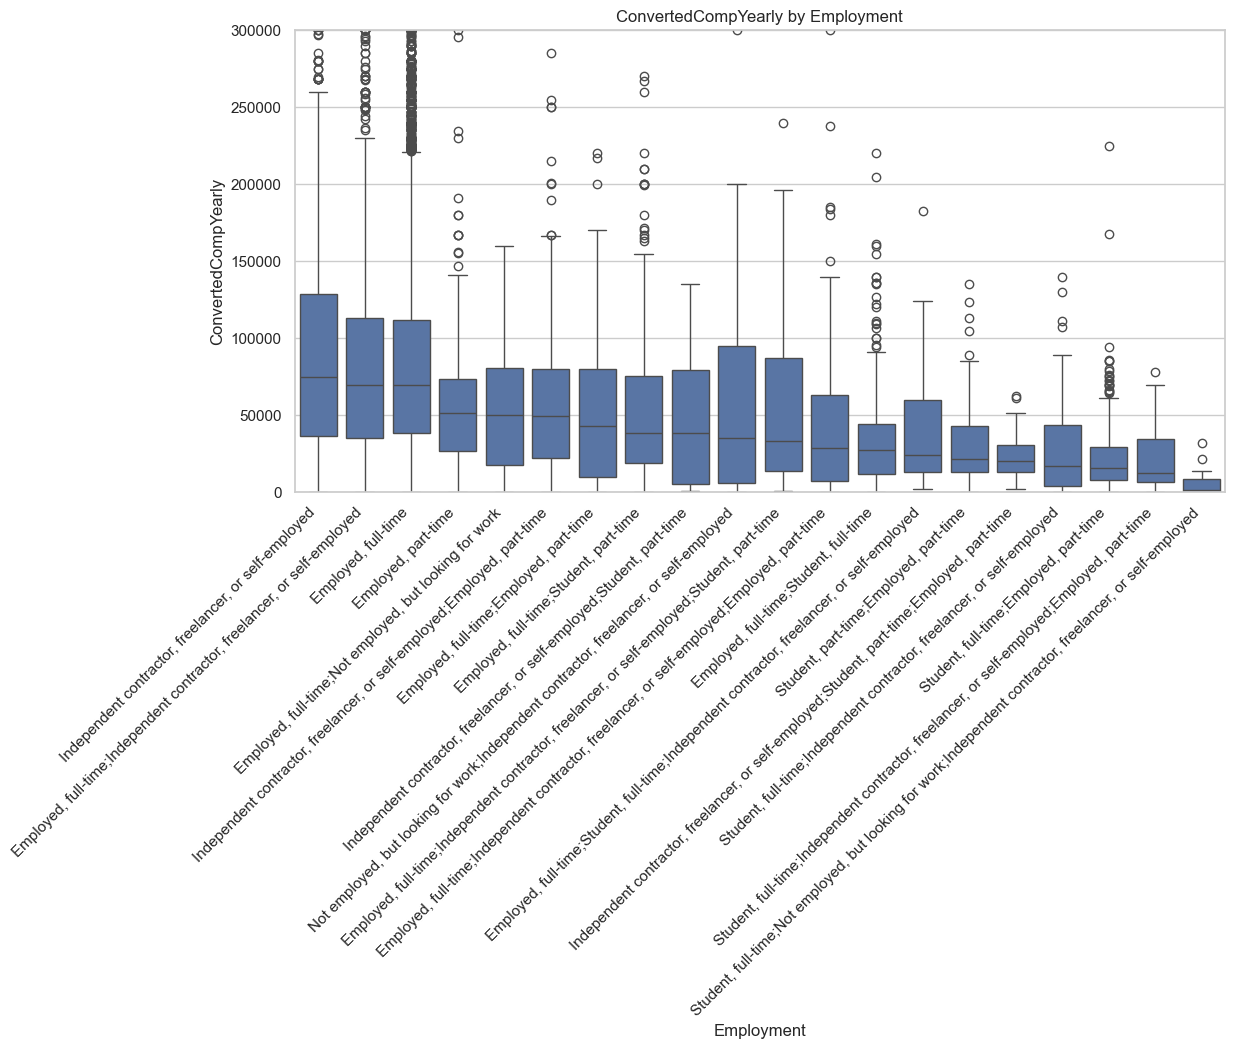

In [60]:
# --- Exploring Potential Categorical Features (Using generated list) ---
print("\n--- Exploring Identified Categorical Features ---")
# Use the list generated from summary_df
print(df_cleaned[categorical_candidates].isnull().sum()) # Use df_cleaned

# Visualize relationship with target using the helper function
print("\n--- Visualizing Categorical vs Target ---")
# Use the list generated from summary_df
for col in categorical_candidates:
    plot_boxplot_category(df_cleaned, col, TARGET_VARIABLE, ylim_max=300000) # Call the function



**Numeric Feature Observations:**
*   `WorkExp` and `YearsCodePro` show a positive correlation with compensation, although the relationship appears non-linear with increasing variance at higher experience levels.
*   `CompTotal` (raw compensation before conversion) has extreme outliers and high missingness, making `ConvertedCompYearly` a better target.
*   The `JobSatPoints_X` features have moderate correlations but also significant missingness. Their direct interpretation regarding compensation might be complex. *(Adjust based on your actual plots)*

**Categorical Feature Observations:**
*   `EdLevel` generally shows higher median compensation for advanced degrees (Master's, Doctoral).
*   `DevType` reveals significant compensation differences, with roles like Engineering Manager or SRE often associated with higher pay compared to front-end or mobile developers (within the top 20 shown).
*   `Country` confirms the strong geographical variations seen in Q2.
*   `RemoteWork` status shows only slight differences in median compensation in the boxplot. *(Adjust based on your actual plots)*


### Selecting Features for the Linear Regression Model

Based on the feature exploration and aiming for a relatively simple baseline model:
*   **Target:** `ConvertedCompYearly` (using the original scale for interpretability, though log-transform was considered).
*   **Selected Numeric Features:** `WorkExp`, `YearsCodePro`. These showed the clearest positive relationship with compensation. Other numeric candidates like `CompTotal` were excluded (redundant/raw), and `JobSatPoints_X` / `JobSat` were excluded due to high missingness and less direct expected link compared to experience.
*   **Selected Categorical Features:** `EdLevel`, `DevType`, `Country`, `RemoteWork`, `OrgSize`. These represent key demographic and job context factors identified as relevant during exploration. `Age` was considered but might be highly correlated with `WorkExp`/`YearsCodePro`, so excluded for simplicity. High-cardinality features like `Employment` were excluded for this baseline model.

These selected features will be used as input `X` for the model after appropriate preprocessing (which was performed in the Data Preparation section).



In [61]:
# --- Modeling Q3 ---
# Rationale: Build a baseline Linear Regression model to identify key drivers.
# Note: Preprocessing (numeric conversion, fillna) should have been done in Data Preparation.
# The df_cleaned dataframe should be used here.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

# Define features based on selection justification above
features_for_model = [
    'WorkExp', 'YearsCodePro', # Selected Numeric
    'EdLevel', 'DevType', 'Country', 'RemoteWork', 'OrgSize' # Selected Categorical
]

# Ensure df_cleaned is ready (use the dataframe prepared in section 4)
X = df_cleaned[features_for_model].copy()
y = df_cleaned['ConvertedCompYearly']

# --- One-Hot Encoding (Should ideally be in Data Prep, but can be here if needed just before splitting) ---
# Rationale: Convert categorical features into a format suitable for the linear model.
categorical_cols_model = X.select_dtypes(include='object').columns
print(f"\n--- One-Hot Encoding features for model: {list(categorical_cols_model)} ---")
X = pd.get_dummies(X, columns=categorical_cols_model, drop_first=True)
print(f"Shape of X after One-Hot Encoding: {X.shape}")

# --- Final Check for NaNs in final X before splitting ---
# Rationale: Crucial check to ensure no NaNs remain after all preprocessing.
if X.isnull().sum().sum() > 0:
    print("Warning! NaNs detected in final feature matrix X:")
    print(X.isnull().sum()[X.isnull().sum() > 0])
    # Add emergency handling if needed, e.g., X.fillna(0, inplace=True)
else:
    print("Final feature matrix X contains no NaNs.")

# --- データの分割 ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- モデルのトレーニング（Linear Regression） ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# --- 予測と評価 ---
y_pred = lr_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nLinear Regression RMSE: {rmse:.2f}")
print(f"Linear Regression R-squared: {r2:.2f}")






--- One-Hot Encoding features for model: ['EdLevel', 'DevType', 'Country', 'RemoteWork', 'OrgSize'] ---
Shape of X after One-Hot Encoding: (23435, 221)
Final feature matrix X contains no NaNs.

Linear Regression RMSE: 91018.08
Linear Regression R-squared: 0.19


/Users/kenadachi/udacity-dsblogpost/venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning:

divide by zero encountered in matmul

/Users/kenadachi/udacity-dsblogpost/venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning:

overflow encountered in matmul

/Users/kenadachi/udacity-dsblogpost/venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning:

invalid value encountered in matmul



**Conclusion for Q3:**

Exploratory Data Analysis (boxplots and scatterplots) suggested that longer professional experience (`WorkExp`, `YearsCodePro`) and geographic location (e.g., USA) are associated with higher compensation.

To quantify this further, a simple Linear Regression model was built using features like experience, education, country, etc. However, the model achieved a very low R-squared value of 0.19. This indicates that these selected features, in a linear combination, explain only a small fraction of the variation in developer salaries.

Therefore, while experience and location seem important based on EDA, predicting compensation accurately is complex and likely depends on many other factors or non-linear relationships not captured by this simple model.


## 6. Conclusions

This notebook explored the Stack Overflow Developer Survey 2024 data to answer key questions about the developer community.


### Summary of Findings

1.  **Q1: Most Common Programming Languages?**
    *   JavaScript, Python, and HTML/CSS were the most frequently used programming languages, reflecting the dominance of web development. SQL and TypeScript also ranked highly.

2.  **Q2: Compensation Variation by Country?**
    *   Significant variation exists globally. After filtering for countries with sufficient responses (>=200), the analysis showed that developers in countries like the **United States, Switzerland, and Israel** reported considerably higher median annual compensation compared to those in countries like India, Brazil, or Ukraine. The data showed a geographic bias towards North America and Europe.

3.  **Q3: Factors Associated with Higher Compensation?**
    *   Exploratory Data Analysis (boxplots and scatterplots) suggested that longer professional experience (`WorkExp`, `YearsCodePro`) and geographic location (e.g., USA) are associated with higher compensation.
    
    * A simple Linear Regression model was built using features like experience, education, country, etc. However, the model achieved a very low R-squared value of 0.19. This indicates that these selected features, in a linear combination, explain only a small fraction of the variation in developer salaries.

### Overall Insights & Limitations

*   **Key Insight:** Developer compensation is strongly tied to experience and geographic location, particularly within the regions well-represented in the survey (North America, Europe).
*   **Modeling Complexity:** Predicting compensation accurately is challenging. The low R² of the simple linear model highlights that many factors beyond basic demographics, experience, and location influence salaries, likely including specific tech stacks, company characteristics, and individual factors.
*   **Data Limitations:**
    *   **Missing Data:** The target variable (`ConvertedCompYearly`) had ~64% missing values, significantly limiting the size and representativeness of the dataset used for modeling. Many other potentially relevant columns also had high missingness.
    *   **Geographic Bias:** The survey respondents are heavily concentrated in North America and Europe, limiting the generalizability of country-specific findings to other regions.
    *   **Schema Gaps:** Lack of question text for some technical columns hindered full understanding.

### Future Work Suggestions

*   Develop more sophisticated models (e.g., Random Forest, Gradient Boosting) to potentially capture non-linear relationships and improve predictive accuracy (R²).
*   Perform more advanced feature engineering, particularly for multi-select columns like `LanguageHaveWorkedWith` or `ToolsTechHaveWorkedWith` (e.g., creating features for specific skill combinations).
*   Investigate feature interactions (e.g., does the impact of experience differ significantly by country?).
*   Address data limitations if possible (though challenging with survey data) or clearly state them when presenting results.
